# Klassifikation von Röntgen-Thoraxbildern mit Convolutional Neural Nets

In diesem Notebook wollen wir uns anschauen, was alles nötig ist, um ein neuronales Netzwerk auf Röntgenthoraxaufnahmen zu trainieren, die Normalbefunde, Befunde bei Patienten mit einer bakteriellen Pneumonie, und Befunde bei Patienten mit COVID-19 beinhalten.

Da Python/Jupyter nur die allernötigsten grundlegenden Funktionen und Datentypen bereitstellt, und man das Rad nicht immer neu erfinden möchte, arbeitet man *sehr viel* mit sogenannten Bibliotheken, die verschiedene vorgefertigte Funktionalitäten bereitstellen.

Einige haben sie im Rahmen des Programmierkurses schon kennen gelernt. Man fügt Bibliotheken oder Teile davon mit dem "import" Befehl hinzu.

### Cave

Die Anzahl an verfügbaren Röntgen-Thoraxaufnahmen hat sich seit der Erstellung dieser Notebooks deutlich erhöht. Die Diskussion bezieht sich noch auf den Stand im Sommer 2020, als noch *sehr wenige* Röntgenthoraxaufnahmen von COVID-19 Pneumonien frei verfügbar waren. Wundern sie sich also nicht, falls die Zusammensetzung ihres Datensatzes nicht den in der Diskussion genannten Zahlenwerten entspricht.

### Einrichten der Umgebung

Fangen wir damit an, die Bibliotheken, die wir brauchen werden, zu importieren.

In [1]:
# PyTorch ist neben TensorFlow eines der zwei großen "Frameworks" für
# Deep-Learning, es stellt die Grundlegenden Funktionen bereit, um tiefe neuronale Netze
# zu Trainieren und Anzuwenden. Man importiert PyTorch
# und verschiedene Sub-Module wie folgt:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

# Etwas Zufall ist nie schlecht, sonst wird das Leben so langweilig
# Random stellt Zufallszahlen und zufällige Operationen bereit, z.B. um Listen zufällig zu "Mischen"
import random

# Zufallszahlen können auf einem deterministischem Computer nie wirklich zufällig sein, aber es gibt
# Algorithmen, die so schwer vorherzusagen sind, dass die resultierenden Ausgaben sehr zufällig
# "aussehen". Dennoch sind diese Sequenzen immer deterministisch. D.h. startet man bei einer bestimmten Zahl,
# so erhält man immer eine bestimmte nächste Zahl, usw.
# Als "Seed" eines "Zufallszahlengenerators" bezeichnet man die Zahl, bei der man diese pseudozufällige Sequenz beginnt.
random.seed(0)

# Um Ergebnisse darzustellen benutzen wir matplotlib und seaborn, das auf matplotlib aufbaut.
# Beides sind tolle Bibliotheken um schicke Abbildungen zu machen (bestimmt auch für Doktor- und andere Abschlussarbeiten nützlich)
# matplotlib: https://matplotlib.org/
# seaborn: https://seaborn.pydata.org/
import seaborn as sns
import matplotlib.pyplot as plt

# Numpy ist *die* Bibliothek in Python für alles, was mit Zahlen
# und Matrizen zu tun hat.
import numpy as np

# Pandas erlaubt es uns, relativ einfach mit Daten im "Tabellenformat"
# zu arbeiten
import pandas as pd

# Ein wichtiger Faktor in der Entwicklung des maschinellen Lernens war der Zuwachs an günstiger
# paralleler Rechenkapazität, die vor allem durch die Entwicklung immer leistungsfähigerer
# Endandwender-Graphikkarten zum Gaming vorangetrieben wurde.

# Wir testen im folgenden, ob und wieviele Graphikkarten auf dem Notebook-Server zur Verfügung
# stehen und wählen eine davon aus (bitte nicht ändern, sonst kommen sie eventuell
# ihren Mitstudierenden ins Gehege).

gpu_nr = 0
if torch.cuda.is_available():
    print('%d GPU(s) available.' % torch.cuda.device_count())

    if torch.cuda.device_count() > gpu_nr:
        device = "cuda:%d" % gpu_nr
    else:
        device = "cpu"
else:
    device = "cpu"

print('Using device: ' + device)

1 GPU(s) available.
Using device: cuda:0


In [43]:
!git clone https://github.com/kaiu85/cv-workshop/
!cp cv-workshop/Computer_Vision/helper_functions_covid.py .
!cp cv-workshop/Computer_Vision/imagenet_classes.txt .
!cp cv-workshop/Computer_Vision/rochen.jpg .

Cloning into 'cv-workshop'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 68 (delta 8), reused 51 (delta 0), pack-reused 0
Receiving objects: 100% (68/68), 7.83 MiB | 31.33 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [6]:
!wget https://www.dropbox.com/s/b0n0t0001yllzkg/covid_dataset_full.bz2?dl=1 -O covid_dataset_full.bz2

--2023-11-26 12:31:42--  https://www.dropbox.com/s/b0n0t0001yllzkg/covid_dataset_full.bz2?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/b0n0t0001yllzkg/covid_dataset_full.bz2 [following]
--2023-11-26 12:31:42--  https://www.dropbox.com/s/dl/b0n0t0001yllzkg/covid_dataset_full.bz2
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc725623438273c7758c557aaa21.dl.dropboxusercontent.com/cd/0/get/CIS64cuLGsn0S7GFqe5hIAxCz3s5TebQIcw0hI6Ab8QZe82CWPXBFIf3W7ncTT51A1-mmdoGLm-7zu5lGrO_F4PCIM4LkeQgMP61WRJNT6G7HjI2B_2z4jhru6CxnUOwOhN4XVcr6fuJiJSiZUjJEExZ/file?dl=1# [following]
--2023-11-26 12:31:43--  https://uc725623438273c7758c557aaa21.dl.dropboxusercontent.com/cd/0/get/CIS64cuLGsn0S7GFqe5hIAxCz3s5TebQIcw0hI6Ab8QZe82CWPXBFIf3W7ncTT51A1-

In [8]:
!bzip2 -dk covid_dataset_full.bz2

In [13]:
!tar -xf covid_dataset_full

### Sichten der Trainingsdaten

Als nächstes bereiten wir unsere Trainingsdaten vor. Wir haben einen Datensatz aus 15537 PA-Thoraxröntgenbildern zusammengestellt, die unauffällige Befunde, Befunde bei Patienten mit einer bakteriellen Pneumonie und Befunde bei Patienten mit einer COVID-19-Pneumonie beinhalten.

In [35]:
# In dem Ordner 'data_path' liegen unsortiert die 15537 Bilder als jpg oder png-Dateien.
#
# Auf Linux und macOS Systemen werden Ordnerhierarchien mit '/' getrennt
# '..' heißt, einen Ordner in der Hierarchie nach oben gehen.
# '.' bezeichnet den Ordner, in dem man sich gerade befindet.
#
# annotation_file verweist auf eine *lange* Textdatei, die für jedes Bild
# den Dateinamen und die Klasse (COVID, normal, pneumonia) enthält.
# Diese heißt "annotation.txt" und liegt im selben Ordner wie dieses Notebook ('.').
# Schauen sie gerne mal rein.

data_path = './covid_dataset_full/data'
annotation_file = './covid_dataset_full/data.txt'

# Zunächst Lesen wir die Textdatei ein. Wir benutzen dazu das Paket "pandas", das es uns relativ einfach erlaubt,
# mit Daten, die ein "Tabellenformat" haben, zu arbeiten.
data_table = pd.read_csv(annotation_file, sep=' ', header=None, names=['Image','Class'])
# Wir geben dabei der ersten Spalte den Namen "Image" und der zweiten Spalte den Namen "Class"

# Beenden wir eine Zelle mit dem Namen einer Variablen, wird in Jupyter (und Colab)
# die entsprechende Variable ausgegeben, in unserem Fall die Liste der Trainingsbilder mit
# dem jeweiligen Dateinamen und der annotierten Klasse.

data_table

,Image,Class
8,SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9...,pneumonia
31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia
31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia
31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia
31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia
...,...,...
c1628c47-5ba3-42dd-8df3-7ad3abd57ad0,c1628c47-5ba3-42dd-8df3-7ad3abd57ad0.png,pneumonia
c1cddf32-b957-4753-acaa-472ab1447e86,c1cddf32-b957-4753-acaa-472ab1447e86.png,pneumonia
c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2.png,pneumonia
c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8.png,pneumonia


In [18]:
# Wie sie sehen, werden die ersten und die letzten Zeilen ausgegeben.
# Geben wir nun nur die Zeilen aus, die COVID-19 Bilder enthalten

covid = data_table[ data_table['Class'] == 'COVID-19' ]
# Dieser etwas sperrige Ausdruckt heißt:
# "Gibt mir die Elemente von data_table, für die "Class" gleich "COVID-19" ist."

covid

,Image,Class
19,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,COVID-19
19,1-s2.0-S0929664620300449-gr2_lrg-b.jpg,COVID-19
19,1-s2.0-S0929664620300449-gr2_lrg-c.jpg,COVID-19
19,1-s2.0-S0929664620300449-gr2_lrg-d.jpg,COVID-19
20,covid-19-pneumonia-15-PA.jpg,COVID-19
...,...,...
COVID-19(120),COVID-19(120).png,COVID-19
COVID-19(121),COVID-19(121).png,COVID-19
COVID-19(130),COVID-19(130).png,COVID-19
COVID-19(132),COVID-19(132).png,COVID-19


In [19]:
# Wir erstellen nun genau so noch zwei Tabellen, die jeweils die unauffälligen Befunde ("normal") und
# die der bakteriellen Pneumonien ("pneumonia") enthalten.

normal = data_table[ data_table['Class'] == 'normal' ]
pneumonia = data_table[ data_table['Class'] == 'pneumonia' ]

# Nun zählen wir, wie viel von jeder Bildsorte wir haben.
# len(x) gibt hierbei die Länge einer Liste an.
# covid.index enthält die Zeilenindices (1,2,3,...) der covid-Tabelle (ganz linke Spalte)

print('Number of COVID Images:')
print(len(covid.index))

print('Number of Normal Images:')
print(len(normal.index))

print('Number of Pneumonia Images:')
print(len(pneumonia.index))

Number of COVID Images:
617
Number of Normal Images:
8851
Number of Pneumonia Images:
6069


In [20]:
# Mit "[]" können wir auf bestimmte Spalten der Tabellen zugreifen. Die "Image" Spalte enthält die Dateinamen.
# Der Einfachheit halber merken wir uns diese als Listen.
filenames_covid = covid['Image'].tolist()
filenames_normal = normal['Image'].tolist()
filenames_pneumonia = pneumonia['Image'].tolist()

Zunächst schauen wir uns ein paar Beispiele der Trainingsdaten an.
Dafür benutzen wir eine Hilfsfunktion, die den Pfad zu dem Bilderordner sowie eine Liste mit Dateinamen erhält und dann 5 Beispielbilder anzeigt.

Wir beginnen mit PA-Aufnahmen von Patientinnen mit COVID-19

In [32]:
!pip install pytorch-gradcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5247 sha256=3fbdd2849b74e8a76b014015298eb2266b4b0422ee61306101e267884e59752e
  Stored in directory: /root/.cache/pip/wheels/6f/f1/8f/96c81d13f617841f23cae192a77fea3e9e988d058ba9414f2c
Successfully built pytorch-gradcam


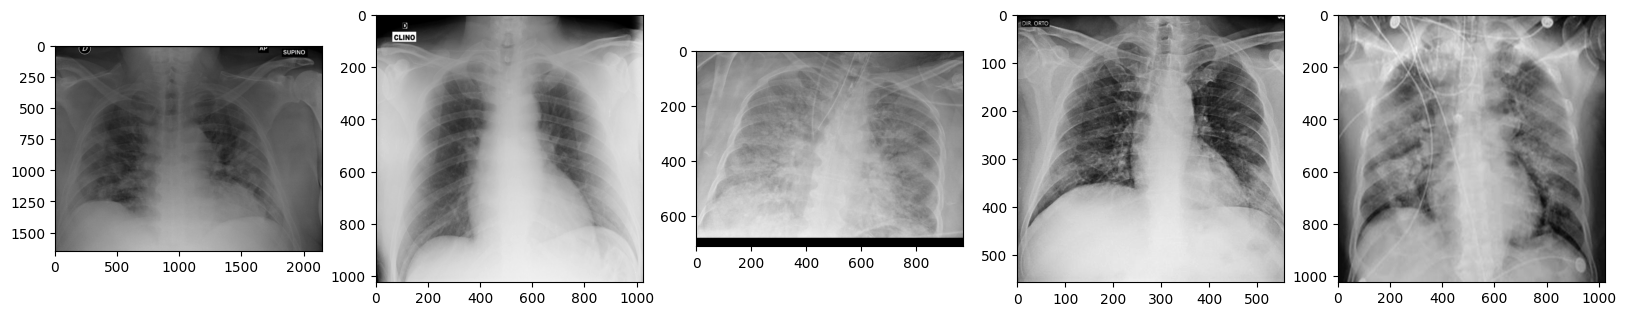

In [44]:
from helper_functions_covid import show_examples

show_examples(data_path, filenames_covid)

Führen sie die vorhergehende Zelle gerne noch einige Male aus und überzeugen sie sich, dass immer andere, zufällig gezogene Beispiele gezeigt werden.

Betrachten sie die Bilder und überlegen sie sich schon einmal, welche Probleme unser Netzwerk später lösen muss.

Einen kleinen Refresher zur Radiologie der akuten COVID-19 Pneumonie gibt es [hier](https://www.bmj.com/content/370/bmj.m2426).

### Erste Aufgabe

Als erste __kleine Aufgabe__: Schreiben sie Code, um sich auch ein paar Beispiele der Normalbefunde und der Befunde bei Patienten mit einer bakteriellen Pneumonie anzuschauen.

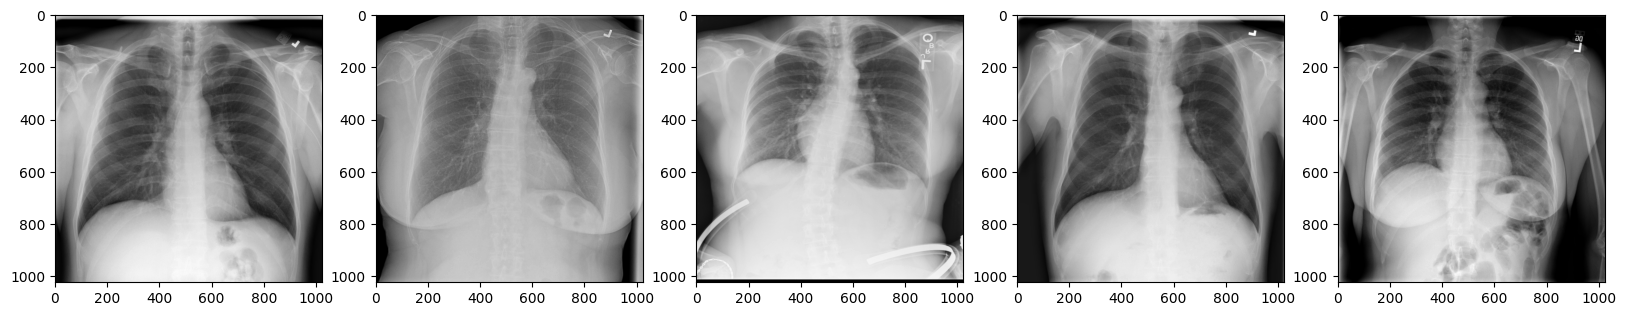

In [45]:
# Schauen wir uns noch ein paar Normalbefunde an

# Hier beginnt ihr Code

# Normalbefunde
show_examples(data_path, filenames_normal)

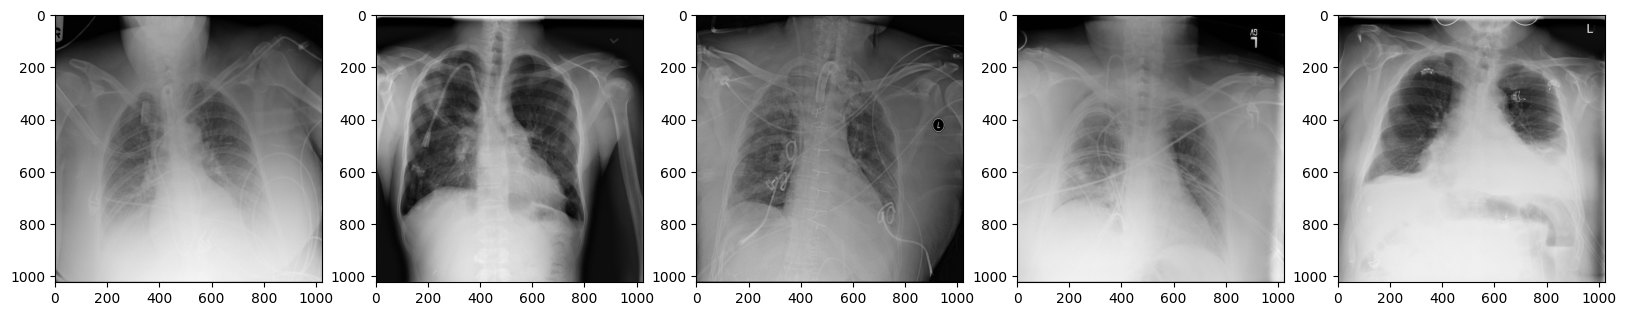

In [46]:
# Und ein paar Befunde von Patienten mit einer bakteriellen Pneumonie

# Hier beginnt ihr Code

# Bakterielle Pneumonie
show_examples(data_path, filenames_pneumonia)

<details><summary>Klicken sie <b>hier</b> für eine mögliche Lösung</summary>
<p>

```python
    
# Normalbefunde
show_examples(data_path, filenames_normal)
# Bakterielle Pneumonie
show_examples(data_path, filenames_pneumonia)
    
```

### Endlich: Neuronale Netze

Wie bereits in der Vorlesung angeklungen ist, ist es eine große Kunst für komplexe Probleme eine passende "Architektur" für ein künstliches neuronales Netz zu finden. D.h. die Anzahl, Typ und Reihenfolge der einzelnen Layer, sowie deren Größe, die Art der Nichtlinearitäten ("Squashing Functions"), ...

Eine sehr gute Einführung und Wiederholung ins Thema "Deep Learning" finden sie hier: https://www.youtube.com/watch?v=5tvmMX8r_OM

Glücklicher Weise ist eines der ersten Probleme, das gut mit künstlichen neuronalen Netzen gelöst wurde, das Erkennen von Gegenständen in Bildern.

Deshalb bietet PyTorch (ebenso wie TensorFlow) schon eine relativ große Bandbreite an optimierten und gut evaluierten Architekturen an, aus denen man sich ein Netzwerk heraussuchen kann. Prinzipiell ist das, wenn man wenig bzw. keine Erfahrung mit dem Design neuronaler Netze hat, meist ein guter erster Schritt.

Bei Bildern ist eine besonders beliebte und erfolgreiche Architektur die der "Convolutional Neural Nets". Diese Netzwerke haben eine Architektur, die gleichzeitig die Anzahl der zu optimierenden Verbindungen bzw. Gewichte reduziert und dabei dem Netz auch das implizite Vorwissen mitgibt, dass die Identität eines abgebildeten Objektes nicht von dessen Position auf dem Bild ("Translationsinvarianz") oder dessen Größe im Bildausschnitt ("Skaleninvarianz") abhängen sollte. Eine sehr gute Einführung in Bildverarbeitung mit tiefen neuronalen Netzen und in Convolutional Neural Netz finden sie hier: https://www.youtube.com/watch?v=AjtX1N_VT9E

Man kann die Netze untrainiert herunterladen, d.h. alle Netzwerkgewichte werden mit zufälligen Werten initialisiert. Oder aber man kann Netzwerke herunterladen, die schon auf bestimmten Standarddatensätzen trainiert wurden. Bei Bildern ist das meist ImageNet, ein Datensatz der mehrere zehntausend Fotos von tausend verschiedenen Klassen enthält. Eine Textdatei, die die einzelnen Klassen aufzählt, finden sie in dem Ordner, in dem auch dieses Notebook liegt. Sie heißt "imagenet_classes.txt". Ausführliche Information zum ImageNet Datensatz und Beispielbilder einzelner Klassen finden sie auf der [ImageNet](http://image-net.org/challenges/LSVRC/2012/analysis/) Homepage.

Um ein Gefühl dafür zu bekommen, wie man mit neuronalen Netzen in Python umgeht, laden wir zunächst ein auf ImageNet vortrainiertes VGG16-Netz (dabei handelt es sich um eine bestimmte Form eines Convolutional Neural Nets, s. https://arxiv.org/abs/1409.1556) herunter und zeigen diesem einige Bilder.

Bildgröße vorher:
(640, 480)
Bildgröße nachher:
torch.Size([3, 224, 224])


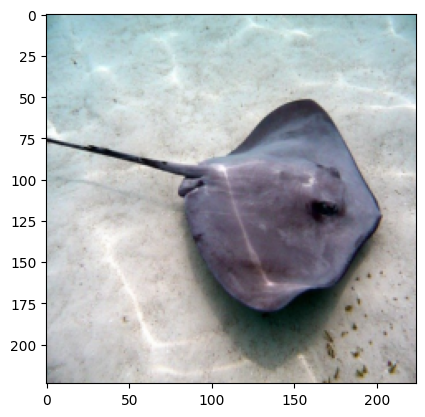

In [48]:
from PIL import Image

# Wir importieren die Klasse "vgg16", die Methoden bereitstellt, um
# (vortrainierte) Netze dieser Architektur zu erzeugen
from torchvision.models import vgg16

# Eine Funktion, die die Bilder so zuschneidet, dass sie zum Input Format (224x224 Pixel)
# des Netzwerkes passen.
from helper_functions_covid  import val_transformer

# Wir erzeugen eine Instanz der Modellklasse vgg16, die auf Imagenet vortrainiert wurde (pretrained == True)
# und schicken sie mit .to(device) direkt auf die Graphikkarte, die wir für die Berechnungen benutzen
vgg = vgg16(pretrained=True).to(device)

# Zu demonstrationszwecken laden wir das (rechtefreie) Beispielbild rochen.jpg, das sich im gleichen Ordner befindet,
# wie dieses Notebook (Tip: Über den Upload-Button der Ordner-Ansicht kann man auch eigene Dateien auf den
# Jupyter-Server hochladen, allerdings kommt in der nächsten Zelle auch ein einfacherer Weg, wie sie das Netz
# auf eigenen Bildern ausprobieren können)

# Bild laden
img = Image.open('rochen.jpg')

# Bildgröße vorher ausgeben
print('Bildgröße vorher:')
print(img.size)

# Bild für das Netzwerk transformieren
img_t = val_transformer(img)

# Bildgröße nachher ausgeben
print('Bildgröße nachher:')
print(img_t.shape)

# Bild anzeigen
plt.imshow(img_t.permute(1,2,0))

<details><summary>Warum ist die Größe 3x224x224? Klicken sie <b>hier</b> für die Antwort.</summary>
<p>
Es handelt es sich um ein Farbbild mit 3 Kanälen R G B. Können Sie sich die einzelnen Kanäle anzeigen lassen?

In [49]:
# Wir verpacken das Bild noch so, dass das Netzwerk es als Input annimmt
# Dazu machen wir aus dem einzelnen Bild einen Stapel (engl. "batch").
# Das Netzwerk erwartet nämlich immer einen ganzen Stapel an Bildern, die parallel verarbeitet
# werden, um die Parallelität moderner Hardware (Graphikkarten, ...) besser auszunutzen.
# Dieser Stapel enthält in unserem Fall zwar nur ein einziges Bild, aber damit
# das Netzwerk versteht, was es tun soll, müssen wir diese formale Konvention erfüllen.
# Deshalb fügen wir einen "Stapelindex" als erste Dimension hinzu (mit unsqueeze) und schicken dann den "Stapel"
# zur Graphikkarte
batch_t = torch.unsqueeze(img_t, 0).to(device)

# Wir setzen das Netzwerk in den Auswerte-Modus (manche Netze werden während des Trainings etwas anders ausgewertet
# als wenn sie fertig trainiert im Einsatz sind)
vgg.eval()

# Dieser unscheinbare Befehl schickt unseren Bilderstapel (bestehend aus einem einzelnen Bild)
# auf der Graphikkarte durch das neuronale Netz und liefert die Vorhersagen des neuronalen
# Netzes für die Klasse des dargestellten Objektes. Dabei kennt das Netz natürlich nur die
# 1000 Klassen, die im ImageNet Datensatz vorhanden sind, auf dem es trainiert wurde.
out = vgg(batch_t)

# Wir schauen uns die Output-Struktur mal an.
print(out.shape)

torch.Size([1, 1000])


In [50]:
# Wir sehen, dass wir ebenfalls einen Stapel erhalten haben, der einen einzelnen Vektor mit
# 1000 Einträgen erhält. Diese können wir in die Wahrscheinlichkeit umrechnen, die das
# neuronale Netz für jede der 1000 ImageNet Klassen vorhergesagt hat. Dazu haben wir eine
# kleine Hilfsfunktion geschrieben
from helper_functions_covid import print_imagenet_predictions

# Gibt die 5 Klassen mit der höchsten vorhergesagten Wahrscheinlichkeit aus
print_imagenet_predictions(out,5)

Prediction: stingray
Probability: 97.899170

Prediction: electric ray, crampfish, numbfish, torpedo
Probability: 2.047429

Prediction: shovel
Probability: 0.048518

Prediction: spatula
Probability: 0.001807

Prediction: hammerhead, hammerhead shark
Probability: 0.000651



Das Netzwerk erkennt den Rochen also relativ gut. Das liegt daran, dass "stingray" eine der 1000 Klassen ist, die im ImageNet-Datensatz enthalten sind und mit denen das Netz trainiert wurde. Falls sie möchten, können sie sich eine Liste der 1000 Klassen [hier](imagenet_classes.txt) anschauen.

Beispiele der Bilder und eine genaue Beschreibung des Datensatzes, mit dem die Netze vortrainiert worden sind, finden sie auf der [ImageNet](http://image-net.org/challenges/LSVRC/2012/analysis/) Homepage.

Wenn sie die nächste Zelle ausführen, erscheint ein kleiner Upload-Button. Falls sie möchten, können sie hier ein eigenes Bild (z.B. aus dem Web) hochladen und das Netzwerk einen Tipp abgeben lassen, was darauf zu sehen sein könnte.

__Beachte:__ Nach dem erfolgreichen Upload ändert sich die Zahl hinter "Upload" von "(0)" zu "(1)".
Führen sie dann die nächste Zelle auf, um das Bild anzuzeigen und die Vorhersage zu starten.

In [51]:
# Die nächsten 3 Zeilen erzeugen nur ein Upload Widget
import ipywidgets as widgets
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

Prediction: wig
Probability: 58.541603

Prediction: cloak
Probability: 8.292400

Prediction: hoopskirt, crinoline
Probability: 6.352671

Prediction: gown
Probability: 5.442559

Prediction: hair spray
Probability: 3.800261



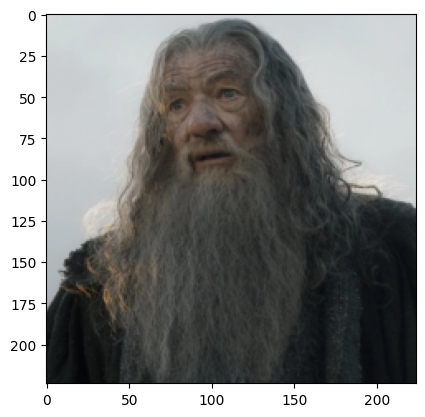

In [52]:
from helper_functions_covid import predict_imagenet_class_from_upload

# Formatiert den Upload als Stapel, schickt ihn durchs Netzwerk, wertet die
# Vorhersagewahrscheinlichkeiten aus und zeigt die Top-5 Klassen an.
# Ganz analog zum Beispiel oben.
predict_imagenet_class_from_upload(vgg, uploader, 5, device)

### Vorgefertigte (und evtl. auch vortrainierte) Netzwerke an eigene Daten anpassen

Das Netz, das wir gerade geladen haben wurde trainiert um auf Fotos 1000 (tausend!) verschiedene Objektklassen zu erkennen. Das gleiche gilt für viele weitere CNN-Architekturen, die auf dem ImageNet-Datensatz entwickelt und trainiert wurden.

Wir können dieses Netz bereits trainiert herunterladen, in der Hoffnung, dass gewisse Features, z.B. Ecken, Kanten oder Texturen, die bei der Klassifikation von Autos, Hunden, Topfpflanzen oder anderen Gegenständen eine Rolle spielen, uns auch bei unserem Problem weiterhelfen werden. Wir können die Netzwerke jedoch auch zufällig initialisiert laden und lediglich die vorgefertigte Netzwerkarchitektur nutzen.

So oder so: Da wir in unseren Daten jedoch 3 Klassen (normal, bakterielle Pneumonie, COVID-Pneumonie) haben, die bereitgestellten Netzwerkarchitekturen jedoch auf dem ImageNet-Datensatz mit 1000 Klassen trainiert und evaluiert worden sind, müssen wir solche vorgefertigen Netzwerk etwas verändern, damit sie auf unsere Daten anwendbar sind.

In der Praxis ist es meist so, dass das letzte Layer eines Klassifikationsnetzwerkes ein "Fully-Connected" Layer ist, welches eine hochdimensionalen Repräsentation des präsentierten Bildes auf ein Output-Layer weiterleitet, in dem jedes Output-Neuron für eine der Objektklassen steht.

In dem VGG-Netzwerk oben beinhaltet das letzte "hidden layer" z.B. 4096 Neurone, die eine gelernte, kompakte Repräsentation des gezeigten Bildes darstellen. Diese werden über ein Fully-Connected Layer mit den 1000 Output-Neuronen verbunden, eines für jede ImageNet-Klasse.

In solchen Fällen müssen wir lediglich die Anzahl der Output-Neurone auf die Anzahl der Klassen in unserem Datensatz ändern und das letzte Fully-Connected Layer entsprechend anpassen.

Wir haben für sie eine Hilfsfunktion bereitgestellt, die dies für fünf bekannte Netzwerkarchitekturen erledigt. Diese sind "VGG" (s. oben), "AlexNet", "DenseNet", "ResNet" und "SqueezeNet". Sie können zudem auswählen, ob das Netz mit vortrainierten Gewichten (auf dem ImageNet-Datensatz) oder mit zufällig initialisierten Gewichten geladen werden soll. Ob das Vortrainieren auf natürlichen Bildern tatsächlich Vorteile für neuronale Netze auf __medizinischen Bildgebungsdaten__ liefert, ist noch Gegenstand aktueller Forschung. Die finale Performance der Netze, wenn diese lange auf großen medizinischen Datensätzen trainiert werden, wird durch Vortraining auf natürlichen Bildern meist nicht signifikant verbessert. Die Trainingsgeschwindigkeit und die Ergebnisse auf kleinen Datensetzen können jedoch eventuell positiv beeinflusst werden.

Auf dieser [Seite](https://www.jeremyjordan.me/convnet-architectures/) finden sie kurze Steckbriefe von VGG-16, AlexNet, DenseNet, und ResNet. Diese Netzwerke haben mehrere zehn Millionen freie Parameter oder mehr. Außerdem haben wir eine SqueezeNet-Architektur vorbereitet. Dieses heißt so, weil sie entwickelt wurde, um auf ein mobiles Endgerät "gequetscht" zu werden, so dass z.B. ein Smartphone auch Objekte erkennen kann, ohne dass vorher Bilder "in die Cloud" (d.h. auf den Computer von jemand anderem) geschickt werden müssen. Einen kurzen Überblick über SqueezeNet finden sie z.b. [hier](https://towardsdatascience.com/review-squeezenet-image-classification-e7414825581a).

Im folgenden erzeugen wir unser angepasstes Netzwerk.

In [53]:
from helper_functions_covid import get_pretrained_model
# Für die Modellarchitektur können sie aus folgenden Architekturen wählen:
# 'vgg', 'squeezenet', 'resnet', 'alexnet' und 'densenet'
#
# Mit dem pretrained-Parameter bestimmen sie, ob das Netz vortrainiert (True)
# oder zufällig initialisiert (False) geladen werden soll.
model = get_pretrained_model('squeezenet', pretrained = True)

# Wir schicken das Netzwerk auf die Graphikkarte
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 51.6MB/s]


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

Der Output gibt uns eine kurze Zusammenfassung der Netzwerkarchitektur. Dieser ist leider relativ schwer zu lesen. Falls sie sich für die Details interessieren, gibt es mehr Details [hier](https://towardsdatascience.com/using-predefined-and-pretrained-cnns-in-pytorch-e3447cbe9e3c).

In der nächsten Zelle können wir eine Funktion benutzen, die uns eine etwas strukturiertere Übersicht über die Architektur gibt, und auch eine Abschätzung, wie viel Arbeitsspeicher auf der Graphikkarte das Training mit einer gegebenen Batch-Size ("Stapelgröße", Anzahl der Trainingsbeispiele, die parallel verarbeitet werden) benötigt.

Nur für das Densenet funktioniert das leider nicht, da die Bibliothek die wir nutzen, nicht mit der DenseNet-Architektur zurecht kommt, in der jedes Layer eines "Dense"-Blockes nicht nur Inputs von direkt vorhergehenden Layers, sondern von *allen* vorhergehenden Layers des Blockes bekommt. So ist es leider manchmal.

Probieren sie gerne die verschiedenen Netzwerkarchitekturen aus und vergleichen sie z.B. die Anzahl der Parameter und den Speicherverbrauch von __VGG und SqueezeNet__.

Schauen sie auch gerne, was mit dem Arbeitsspeicherverbrauch passiert, wenn sie den __batch_size__-Parameter ändern.

In [54]:
from torchsummary import summary

# Mit dem Summary Befehl erhalten wir eine kurze Zusammenfassung
# der Architektur unseres Modells, und wieviel Speicher es verbrauchen
# würde, wenn man acht Bilder mit drei Farbkanälen und 224x224 Pixeln
# verarbeiten würde. Damit bekommt man auch eine realistische Einschätzung,
# wieviel Arbeitsspeicher man dafür auf der Graphikkarte braucht.
if model.name != 'densenet':
    summary(model,input_size = (3,224,224),batch_size = 8)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 111, 111]           1,792
              ReLU-2          [8, 64, 111, 111]               0
         MaxPool2d-3            [8, 64, 55, 55]               0
            Conv2d-4            [8, 16, 55, 55]           1,040
              ReLU-5            [8, 16, 55, 55]               0
            Conv2d-6            [8, 64, 55, 55]           1,088
              ReLU-7            [8, 64, 55, 55]               0
            Conv2d-8            [8, 64, 55, 55]           9,280
              ReLU-9            [8, 64, 55, 55]               0
             Fire-10           [8, 128, 55, 55]               0
           Conv2d-11            [8, 16, 55, 55]           2,064
             ReLU-12            [8, 16, 55, 55]               0
           Conv2d-13            [8, 64, 55, 55]           1,088
             ReLU-14            [8, 64,

### Learning Rate und Optimizer

Wie in der Vorlesung besprochen, ist bei gradientenbasierten Optimierungsverfahren die Wahl einer passenden "Schrittweite" in Richtung der Gradienten der Zielfunktion wichtig. Ist die Schrittweite zu klein, dauert es mitunter sehr, sehr lange, bis das Netzwerk eine gute Performance erreicht. Ist die Schrittweite zu groß, kann es tatsächlich sein, dass es überhaupt nichts sinnvolles lernt, da es immer wieder aus den entsprechenden lokalen Minima der Zielfunktion herausspringt.

Als kleinen Exkurs können sie in der nächsten Zelle mit einer Funktion spielen, die einen Gradientenabstieg auf einer eindimensionalen, quadratischen Zielfunktion simuliert. D.h. es gibt nur einen einzigen, skalaren Parameter theta, und die Zielfunktion ist eine quadratische Funktion dieses Parameters. Sie können mit __theta_start__ bestimmen, von welchem Parameter-Wert der Gradientenabstieg starten soll. Zudem können sie die Lernrate __learning_rate__ bestimmen, die skaliert, wie groß die Optimierungsschritte in Richtung des Minimums sein sollen. Außerdem können sie mit __n_steps__ angeben, wie viele Optimierungsschritte gemacht werden sollen.

Als Output erhalten sie zwei Graphen. Der Linke zeigt die Zielfunktion (blau) als Funktion des Parameters theta, und wie sich die Parameter-Werte mit jedem Optimierungsschritt vom Startwert (dunkelblauer Marker) zum finalen Wert (roter Marker) ändern (orangene Pfeile).

Rechts sehen sie den Wert der Kostenfunktion als Funktion des Optimierungsschrittes. Ein funktionierender Optimiser sollte am Schluss ziemlich nahe am Minimum __0__ der Kostenfunktion sein.

Spielen sie etwas mit den Parametern. Beobachten sie dabei, was passiert wenn sie die Lernrate sehr klein (z.B. 0.01) oder sehr groß (z.B. 2.0) machen. Schauen sie, wie schnell der Algorithmus für sinnvolle Werte (in diesem Beispiel z.B. 0.3) der Lernrate zum Minimum konvergiert.

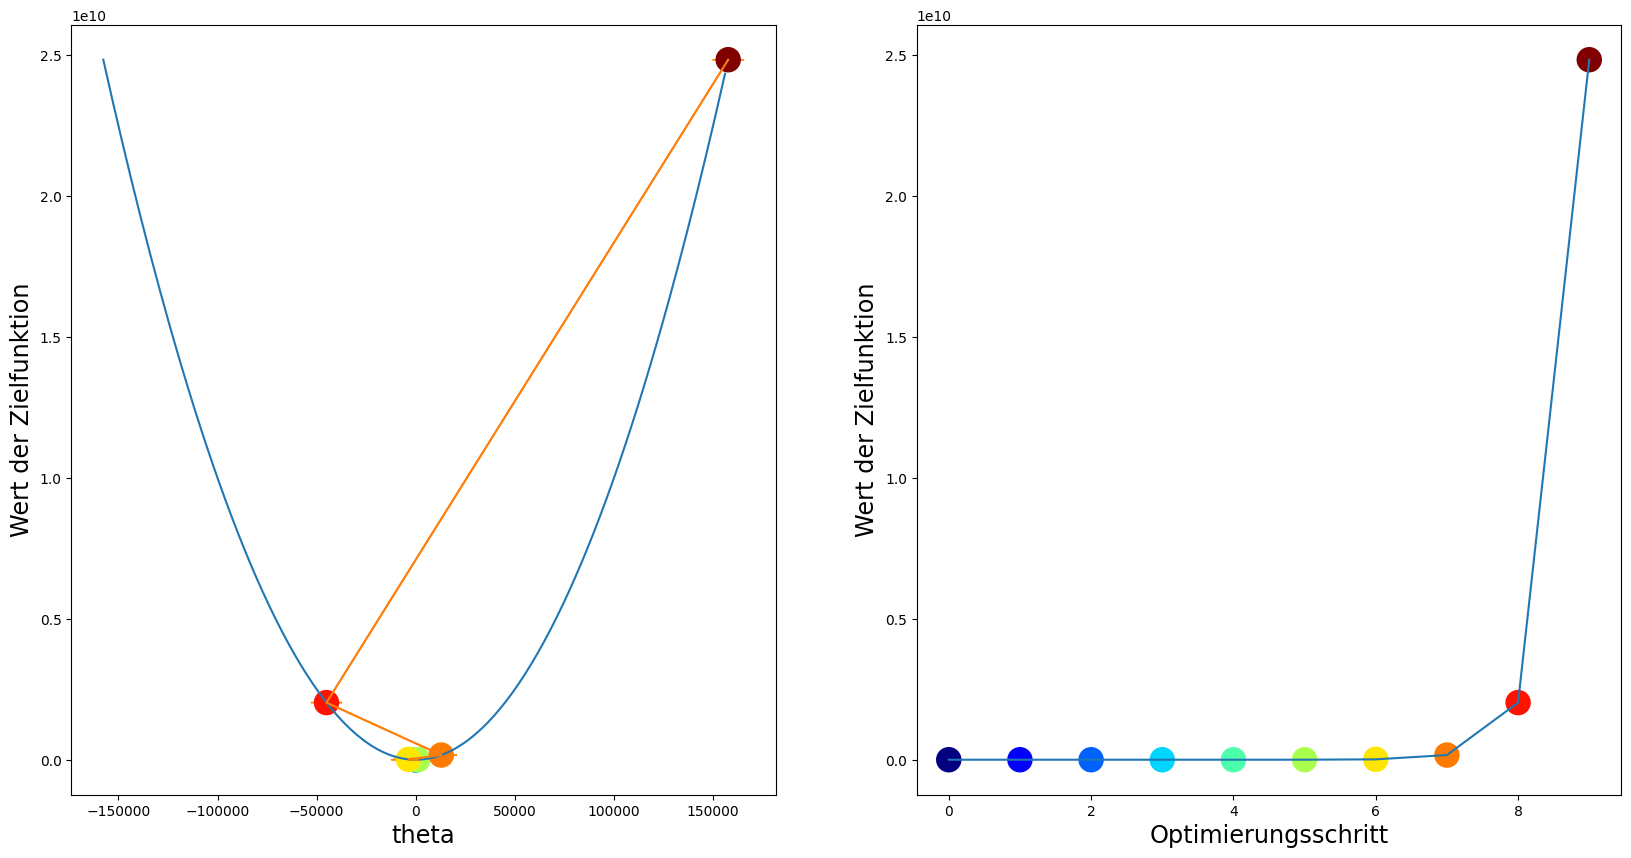

In [60]:
from helper_functions_covid import simulate_gradient_descent_on_quadratic_potential

# Lernrate (probieren sie z.B. 0.02, 0.05, 0.1, 0.2, 0.3, 0.6, 0.9, 1.0, 1.1)
learning_rate = 2.25

# Anzahl der simulierten Schritte
n_steps = 10
# Startwert für den Parameter theta
theta_start = -2.0
simulate_gradient_descent_on_quadratic_potential(theta_start, learning_rate, n_steps)

Wie sie sehen, hat die Wahl der Lernrate einen kritischen Einfluss auf das Konvergenzverhalten von gradientenbasierten Optimierungsverfahren. Umso unbefriedigender ist es, dass es noch keine wirklich fundierte Methode gibt, diese festzulegen. In der Praxis ist meistens eine Menge Ausprobieren involviert, in dem man z.B. numerische "Experimente" durchführt, die einen ganzen Bereich von Lernraten ausprobieren.

Üblicher Weise funktionieren Lernraten im Bereich von 0.00001 - 0.001.

In der folgenden Zelle haben sie die Wahl der Lernrate und des gradientenbasierten Optimierungsverfahrens für unser Convolutional Neural Net. Auch hier gibt es einen ganzen Forschungszweig, der sich damit beschäftigt, neue Optimierungsverfahren zu entwickeln, die schneller und zuverlässiger konvergieren. Wir bieten ihnen hier zwei Verfahren an:
- SGD oder "stochastic gradient descent" ist der absolute Klassiker, der tatsächlich genau das macht, was wir Ihnen in der Vorlesung gesagt haben. Also: Den Gradienten der Zielfunktion bestimmen und dann einen Schritt entgegen diesem Gradienten (erinnern sie sich, dass der Gradient einer Funktion die Richtung des __steilsten Anstieges__ ist) gehen, der mit der Lernrate skaliert wird. Dieser Algorithmus konvergiert bei genügend kleinen Lernraten fast immer und findet Minima, die gut generalisieren. Er ist jedoch auch sehr __langsam__. In der erweiterten Version, die wir hier benutzen gibt es noch einen Parameter, __"momentum"__, der dem Optimierungsprozess eine gewisse __Trägheit__ verleiht. Stellen sie sich eine schwere Metallkugel vor, die einen bergigen Hang hinunterrollt. Wenn diese auf eine kleine Mulde trifft, wird sie nicht in diesem lokalen Minimum hängen bleiben, sondern aufgrund ihrer Trägheit darüber hinwegrollen.
- ADAM oder "adaptive moment estimation" hat sich seit seiner [Publikation](https://arxiv.org/pdf/1412.6980.pdf) 2014 zum "Schweizer Taschenmesser" der gradientenbasierten Optimierungsverfahren entwickelt. Das liegt daran, dass dieser Algorithmus, der seine Schrittweite während des Optimierungsprozesses anpasst, mit seinen Standardparametern über viele Anwendungen, Netzwerkarchitekturen und Zielfunktionen hinweg nicht immer die beste, aber immer eine passable Leistung bietet.

In [61]:
# Wählen sie eine Lernrate zwischen 0.00001 und 0.001
learning_rate = 0.0001

# Wählen sie einen der beiden Optimizer, in dem sie die entsprechende Zeile einkommentieren.
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
#optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)

### Trainings-, Test- und Validierungsset

Ein großes Problem an Modellen, die Millionen an freien Parametern haben, ist das sogenannte Overfitting. Hierbei ist das Modell so flexibel, dass es nicht nur die Regularitäten bzw. die Struktur in den Daten aufgreift, sondern auch das __zufällige Rauschen in den Daten lernt__. Das führt natürlich dazu, dass solch ein zu flexibles Modell schlecht generalisiert, d.h. schlecht neue Datenpunkte, die ein anderes zufälliges Rauschen mitbringen, vorhersagt.

In der nächsten Zelle können sie ausprobieren, einen Datensatz (blaue Punkte), der auf Grundlage einer deterministischen Funktion (orange) mit additivem, zufälligen Rauschen generiert wurde, durch ein Polynom anzupassen. Dabei gibt der Grad des Polynoms an, wie viele freie Parameter angepasst werden können. Ein Grad von eins entspricht dabei einer Geraden mit zwei freien Parametern (Steigung und y-Achsenabschnitt). Ein Grad von zwei entspricht einer quadratischen Funktion mit drei freien Parametern, usw...

In der folgenden Zelle können sie der Funktion __plot_overfitting_demo__ eine Liste mit Graden (1,2,3,...) übergeben, für die jeweils ein Polynom des entsprechenden Grades an die Stichprobe gefittet wird. Die entsprechenden Graphen werden nebeneinander dargestellt (ab 4 wird es ziemlich gequetscht).

Probieren sie gerne einmal aus, wie sich die Annäherung an die Daten verändert, wenn man von sehr einfachen Funktionen (Grad 1) zu __sehr, sehr komplizierten (Grad 100) geht__. Beachten sie dabei, dass mit zunehmendem Grad der mittlere quadratische Fehler auf der Stichprobe immer kleiner wird, die Annäherung der __wahren Funktion (orange)__ durch das __Modell ("Polynom", blau)__ aber nicht unbedingt besser.

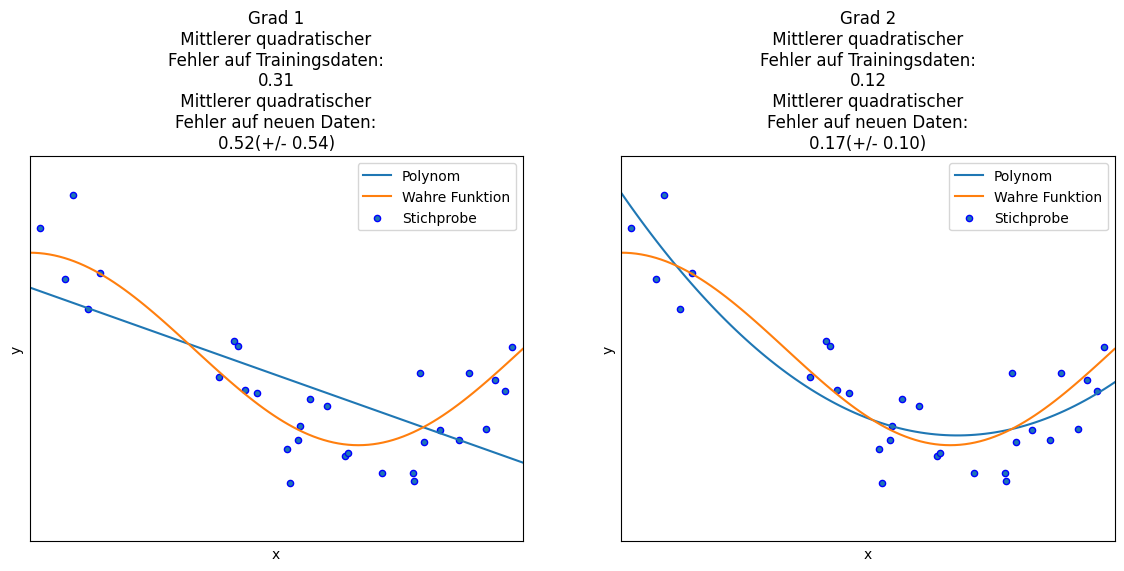

In [62]:
from helper_functions_covid import plot_overfitting_demo

# Gerne auch mehrere Grade in die Liste eintragen, zum vergleichen
grade = [1,2]

plot_overfitting_demo(grade)

In der Praxis hat sich im Deep Learning folgendes Vorgehen durchgesetzt, um Overfitting zu vermeiden:

Man teilt die Daten, mit denen der Algorithmus trainiert wird in drei __unabhängige__ Teilmengen:

- Ein __Trainingsset__: Auf dem Trainingsset wird der Gradient der Kostenfunktion berechnet, der von dem gradientenbasierten Optimierungsalgorithmus genutzt wird, um die Parameter der neuronalen Netze zu optimieren.

- Ein __Validierungsset__: Auf dem Validierungsset wird während des gradientenbasierten Trainings immer wieder die Kostenfunktion ausgewertet. So lange das neuronale Netz noch sinnvolle Struktur aus dem Trainingsset lernt, sollte auch die Kostenfunktion auf dem Validierungsset fallen. Sobald während des Trainings jedoch der Wert der Kostenfunktion auf dem Validierungsset zu steigen beginnt, während er auf dem Trainingsset weiter fällt, geht man davon aus, dass das Netz beginnt zu "überfitten" und beendet das Training. Dies wird in der Literatur als __early stopping__ bezeichnet.

- Ein __Testset__: Das Testset wird benutzt, um die finale Performance des trainierten Netzwerkes zu überprüfen. Es muss vom Trainings- und Validierungsset möglichst komplett unabhängig sein.

Bevor wir also mit dem Training unseres Netzes auf den Röntgenbildern beginnen können, teilen wir die drei Listen, die die Röntgenbilder der Normalbefunde, COVID-Erkrankungen und bakteriellen Pneumonien beinhalten, jeweils in diese drei Untermengen auf.

Dafür haben wir eine Helferfunktion geschrieben, __split_list__, die die Listen zufällig in ein Trainings-, Validierungs- und Testset aufteilt. Man kann der Funktion die relative, prozentuale Aufteilung in die drei Sets in Form der Parameter train_percentage, validation_percentage, und test_percentage übergeben.

Üblich sind z.B. ein Split von 80% der gesamten Trainingsdaten als Trainingsset, und je 10% als Validierungs- und Testset.

Wählen sie auch gerne eine andere Aufteilung, z.B. 60%/20%/20%.

Nebenbemerkung: Eine weitere Technik, um Overfitting zu vermeiden, die wir zunächst nicht verwenden, ist das sogenannte Dropout. Mehr dazu finden sie hier: https://www.youtube.com/watch?v=5tvmMX8r_OM&t=2989s

In [63]:
from helper_functions_covid import split_list

train_percentage = 0.8
valid_percentage = 0.1
test_percentage = 0.1

# Nun können wir die Listen entsprechend aufteilen und uns die resultierenden
# Aufteilungen anschauen

# Zunächst für die COVID-Bilder

filenames_covid_train, filenames_covid_val, filenames_covid_test = \
    split_list(filenames_covid, train_percentage, valid_percentage, test_percentage)

print('Training Cases with COVID:')
print(len(filenames_covid_train))

print('Validation Cases with COVID:')
print(len(filenames_covid_val))

print('Test Cases with COVID:')
print(len(filenames_covid_test))

# Nun für die Normalbefunde

filenames_normal_train, filenames_normal_val, filenames_normal_test = \
    split_list(filenames_normal, train_percentage, valid_percentage, test_percentage)

print('Normal Training Cases:')
print(len(filenames_normal_train))

print('Normal Validation Cases:')
print(len(filenames_normal_val))

print('Normal Test Cases:')
print(len(filenames_normal_test))

# Und nun für die Befunde bei bakteriellen Pneumonien

filenames_pneumonia_train, filenames_pneumonia_val, filenames_pneumonia_test = \
    split_list(filenames_pneumonia, train_percentage, valid_percentage, test_percentage)

print('Pneumonia Training Cases:')
print(len(filenames_pneumonia_train))

print('Pneumonia Validation Cases:')
print(len(filenames_pneumonia_val))

print('Pneumonia Test Cases:')
print(len(filenames_pneumonia_test))

Training Cases with COVID:
493
Validation Cases with COVID:
62
Test Cases with COVID:
62
Normal Training Cases:
7080
Normal Validation Cases:
886
Normal Test Cases:
885
Pneumonia Training Cases:
4855
Pneumonia Validation Cases:
607
Pneumonia Test Cases:
607


Für die __Nachvollziehbar- und Reproduzierbarkeit__ sollten solche zufälligen Aufteilungen (__"Splits"__) auch immer __dokumentiert__ werden. Deshalb schreiben wir die einzelnen Listen in der nachfolgenden Zelle in einzelne Textdateien, die sie sich auch gerne über das Jupyter-Interface anschauen können.

In [64]:
from helper_functions_covid import write_list_to_textfile

write_list_to_textfile(filenames_covid_train,'filenames_covid_train.txt')
write_list_to_textfile(filenames_covid_test,'filenames_covid_test.txt')
write_list_to_textfile(filenames_covid_val,'filenames_covid_val.txt')

write_list_to_textfile(filenames_normal_train,'filenames_normal_train.txt')
write_list_to_textfile(filenames_normal_test,'filenames_normal_test.txt')
write_list_to_textfile(filenames_normal_val,'filenames_normal_val.txt')

write_list_to_textfile(filenames_pneumonia_train,'filenames_pneumonia_train.txt')
write_list_to_textfile(filenames_pneumonia_test,'filenames_pneumonia_test.txt')
write_list_to_textfile(filenames_pneumonia_val,'filenames_pneumonia_val.txt')

Das Testset brauchen wir erst später, wenn wir die finale Performance unseres trainierten Netzes beurteilen wollen. __Es schadet aber nie, schon früh daran zu denken, die entsprechenden Daten getrennt von Trainings- und Validierungsset zur Seite zu legen.__

In der nächsten Zelle erstellen wir nun Datensätze, aus denen entsprechende Stapel ("Batches") zum Training des Netzes gezogen werden können.

Eine weitere Möglichkeit, Overfitting zu verhindern, ist die Daten zu __augmentieren__. __Datenaugmentierung__ bezeichnet das Vorgehen, dass man auf die Trainingsdaten, bevor man sie dem Netz präsentiert, Transformationen anwendet, von denen der Output des Netzes unabhängig sein sollte. Geht es zum Beispiel um das Erkennen von Objekten auf Bilder, die an verschiedenen Orten und in verschiedenen Größen auftauchen können, kann man z.B. die Trainingsbilder zufällig verschieben und skalieren. So verhindert man, dass das Netz z.B. lernt, das Hunde immer links unten und Katzen immer rechts oben in den Trainingsbildern waren.

Wir haben eine Sammlung solcher Operationen schon in der "train_transformer"-Struktur zusammengefasst. Diese beinhaltet zufälliges horizontales Spiegeln (quasi vertauschen der rechten und der linken Lunge), und zufälliges Skalieren (etwas vergrößern und verkleinern).

Gleichzeitig werden die Grauwerte normalisiert, so dass sie einen Mittelwert von 0 und eine Standardabweichung von 1 haben. Damit wird auch eine Abhängigkeit vom absoluten Grauwert verhindert.

Zudem werden die Bilder auf 224x224 Pixel skaliert, da die Architekturen, die wir benutzen, auf diese Bildgröße ausgerichtet sind, die der Größe der Bilder im ImageNet-Datensatz entspricht.

Ein wichtiger freien Parameter des Trainings ist auch die Batchsize, die angibt, wie viele Bilder auf einen Trainingsstapel gepackt werden.

Entsprechend des Arbeitsspeichers, der auf den Graphikkarten zur Verfügung steht, und der Größe der Netzwerke ist eine Batch-Size von 8 empfehlenswert. Wenn man ein SqueezeNet-Trainiert kann die Batch-Size allerdings auch erhöht werden. Probieren sie dann gerne 16 aus.

In [65]:
from helper_functions_covid import ImageDataset, train_transformer

batchsize = 8

trainset = ImageDataset(root_dir=data_path,
                          classes = ['normal', 'pneumonia', 'COVID'],
                          files_path = [filenames_normal_train, filenames_pneumonia_train, filenames_covid_train],
                          transform= train_transformer)

valset = ImageDataset(root_dir=data_path,
                          classes = ['normal', 'pneumonia', 'COVID'],
                          files_path = [filenames_normal_val, filenames_pneumonia_val, filenames_covid_val],
                          transform= val_transformer)

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)

Bevor wir mit dem Training anfangen können, brauchen wir noch eine Struktur, die auf das Early-Stopping achtet, also den Trainingsvorgang beendet, wenn die Kostenfunktion auf dem Validierungsset beginnt anzusteigen. Da der Optimierungsprozess aufgrund des zufälligen Ziehens der einzelnen Trainignsstapel auch ein Zufallselement beinhaltet, kann es immer mal vorkommen, dass so ein Anstieg kurz auftritt, ohne dass das Netz bereits zu überfitten beginnt. Deshalb übergibt man EarlyStopping einen Parameter, "patience", der angibt, über wie viele Durchgänge durch das Trainingsset hinweg die Kostenfunktion auf dem Validierungsset kontinuierlich ansteigen darf, bis dem early_stopper "die Geduld ausgeht" und das Training beendet wird.

In [66]:
from helper_functions_covid import EarlyStopping

early_stopper = EarlyStopping(patience = 5)

### Kostenfunktion

Nachdem wir nun einen Datensatz und eine Netzwerkarchitektur haben, müssen wir noch festlegen, welche Kostenfunktion wir minimieren wollen, d.h. mit welcher Kostenfunktion wir die Gradienten bestimmen, die dem Optimizer die Schrittrichtung vorgeben.

Bei Klassifikationsproblemen wählt man meistens die sogenannte "Kreuzentropie" oder "Cross-Entropy". Das klingt zwar sehr kompliziert, aber im wesentlichen funktioniert diese Kostenfunktion so:

- Jede Klasse erhält ein Output-Neuron
- Für jedes Trainingsbeispiel werden die Aktivierungen der Output-Neuronen in eine Wahrscheinlichkeitsverteilung über die einzelnen Klassen umgerechnet, so dass eine höhere Aktivierung eines bestimmten Output-Neurons einer höheren Wahrscheinlichkeit der entsprechenden Klasse entspricht. Dies wird in der Praxis gemacht, in dem man die Aktivierungen der Output-Neurone durch eine sogenannte SoftMax-Funktion schickt.
- Die Kreuzentropie für einen Satz (i.e. ein Batch oder einen Stapel) Trainingsbeispiele ist dann die __mittlere Wahrscheinlichkeit der tatsächlichen, wahren Klasse unter der von Netz vorhergesagten Wahrscheinlichkeitsverteilung__. D.h. diese Zielfunktion sorgt dafür, dass die Wahrscheinlichkeit, die das Netz der tatsächlichen Klasse eines Trainingsbeispiels gibt, immer größer wird. Oder anders gesagt: Dass die Aktivität des Output-Neurons, dass die wahre Klasse eines Trainingsbeispiels repräsentiert, größer wird.

Eine ausführliche Beschreibung dieses Zusammenhanges finden sie z.B. in diesem tollen [Blogartikel](https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451).

Zum Glück bring PyTorch (wie auch TensorFlow) die meisten gebräuchlichen Kostenfunktionen schon mit, so dass es reicht, die entsprechende Struktur aus PyTorchs NeuralNetwork (torch.nn) Bibliothek zu benutzen.

In [67]:
criterion = nn.CrossEntropyLoss()

### Evaluationsmetriken

Neben der Zielfunktion, die benutzt wird, um auf dem Trainingsset den Gradienten (die Ableitung) der Zielfunktion nach den Netzwerkparametern zu berechnen, gibt es noch weitere Metriken, mit denen wir die Performance des Netzes evaluieren können.

### Recall auf den einzelnen Trainingsklassen
Der Recall ist eine Verallgemeinerung der "Sensitivität", die wir schon von einfachen positiv/negativ Tests kennen. Diese kann man als binäre (d.h. es gibt nur zwei Klassen) Classifier betrachten, die Personen in zwei Klassen (gesund/erkrankt) klassifizieren. Hier ist die Sensitivität definiert als die bedingte Wahrscheinlichkeit, dass der test positiv ausfällt, wenn die Person tatsächlich erkrankt ist.

$$\mathrm{Sensitivität = P(positiv|erkrankt)}$$

So eine bedingte Wahrscheinlichkeit kann man für Classifier, die mehrere Klassen zuordnen, für jede einzelne Klasse definieren. Dieses Größe wird der "Recall für die Klasse K" genannt und ist dabei definiert als

$$\mathrm{Recall(K) = P(Classifier\ ordnet\ Klasse\ K\ zu\ |\ Datenpunkt\ hat\ tatsächlich\ Klasse\ K)}$$

__Beachte__, dass unter dieser Definition die "Sensitivität" eines binären Tests der Recall für die Klasse "erkrankt" ist, und die "Spezifität" der Recall für die Klasse "gesund".

### Accuracy
Die Accuracy eines Classifiers auf einem Datensatz ist der relative Anteil der richtig Klassifizierten Punkte. Diese Metrik ist mit __großer__ Vorsicht zu genießen, wenn die einzelnen Klassen in den Trainingsdaten nicht gleich Verteilt sind. Dies ist auch in unserem Beispiel der Fall. Erinnern wir uns an die Verteilung der Klassen in unserem gesamten Datensatz:

```python
    
Number of COVID Images:
617
Number of Normal Images:
8851
Number of Pneumonia Images:
6069
    
```

D.h. wenn wir einen (offensichtlich nutzlosen) Classifier hätten, der __allen Datenpunkten__ die Klasse __normal__ zuordnet, hätte dieser schon eine Accuracy von $8851/(8851 + 6069 + 617) \approx 0.57 = 57\%$. Wenn wir einen Classifier hätten, der alle Bilder der Klassen "normal" und "pneumonia" richtig klassifiziert, aber die Klasse "covid" gar nicht erkennt (sondern die entsprechenden Bilder einer der anderen Klassen zuordnet) wäre die Accuracy schon $(8851+6069)/(8851 + 6069 + 617) \approx 0.96 = 96\%$. Das zeigt, wie sehr diese Kenngröße mit Vorsicht zu genießen ist.

### Precision

Ähnlich wie der Recall die Sensitivität und Spezifität verallgemeinert, verallgemeinert die Precision den Positiven Prädiktiven Wert und den Negativen Prädiktiven Wert eines binären Tests. Die Precision für eine Klasse K ist definiert als die bedingte Wahrscheinlichkeit, dass ein Datenpunkt tatsächlich zu Klasse K gehört, wenn der Classifier ihm Klasse K zuordnet.

$$\mathrm{ Precision(K) = P(Datenpunkt\ hat\ tatsächlich\ Klasse\ K\ |\ Classifier\ ordnet\ Klasse\ K\ zu) }$$

Erinnern wir uns kurz an die bekannten Ausdrücke für binäre Tests: Der Positive Prädiktive Wert ist die Wahrscheinlichkeit, dass eine Person tatsächlich erkrankt ist, wenn der Test positiv ausfällt. Der Negative Prädiktive Wert ist die Wahrscheinlichkeit, dass eine Person tatsächlich gesund ist, wenn der Test negativ Ausfällt. Demnach kann man den Positiven Prädiktiven Wert als die Precision des binären Classifiers (Klassen: gesund/erkrankt) bezüglich der Klasse "erkrankt" betrachten und den Negativen Prädiktiven Wert als die Precision des Classifiers bezüglich der Klasse "gesund".

Ebenso wie bei den binären Tests gilt für die Precision bezüglich einer Klasse: Sie ist nicht nur abhängig von dem Recall des Classifiers für diese und die anderen Klassen (Verallgemeinerung von Sensitivität/Spezifität), sondern auch von der __Vortestwahrscheinlichkeit__ der einzelnen Klassen. D.h. ebenso wie die Accuracy hängt die Precision nicht nur von den eigenschaften des Classifiers, sondern auch von der Verteilung der einzelnen Klassen im jeweiligen Trainings-, Validierungs- und Testdatensatz ab. Dementsprechend nutzen wir diese Größe im Folgenden nicht, sondern beschränken uns damit, den Recall des Classifiers für die einzelnen Klassen anzugeben, der (ganz analog zu Sensitivität und Spezifität) eher die Eigenschaften des Tests bzw. Classifiers __an sich__ beschreibt.

### Confusion Matrix

Precision und Recall als bedingte Wahrscheinlichkeiten können aus der Confusion-Matrix eine Classifiers angegeben werden. Diese gibt für eine Menge an Datenpunkten an, wie viele der gesamten Datenpunkte welche wahre Klasse haben und welche Klasse vom Classifier zugeordnet bekommen.

<img src="https://github.com/kaiu85/cv-workshop/blob/main/Computer_Vision/confusion_matrix.png?raw=1" alt="Eine beispielhafte Confusion-Matrix" title="Eine beispielhafte Confusion Matrix" />

Die Zeilen dieser Matrix (bzw. Tabelle) entsprechen der tatsächlichen Klasse der Datenpunkte, die Spalten entsprechen der Klasse, die ein neuronales Netzwerk den einzelnen Datenpunkten zugeordnet hat. D.h. auf der diagonalen dieser Matrix stehen die Datenpunkte, bei denen die tatsächliche Klasse der zugeordneten Klasse entspricht.

In diesem Beispiel wurden 850 ($8.5\cdot10^2$ in Kurzschreibweise) Datenpunkte, die die wahre Klasse "normal" haben, von Netzwerk auch der Klasse "normal" zugeordnet. Ebenso wurden 530 ($5.3\cdot10^2$ in Kurzschreibweise) Datenpunkte, die die wahre Klasse "pneumonia" haben, auch der Klasse "pneumonia" zugeordnet. Das Netzwerk hat aber auch 78 Datenpunkte, die die wahre Klasse "pneumonia" haben, der Klasse "normal" zugeordnet.

#### Ein paar kleine Aufgaben:

- Wie viele Bilder, die von COVID-Fällen stammen, wurden tatsächlich der Klasse "covid" zugeordnet?
- Wie viele Bilder, die von COVID-Fällen stammen, wurden fälschlicher Weise der Klasse "normal" zugeordnet?
- Was ist die Klasse, die das Netzwerk in diesem Beispiel einem Bild, das von einem COVID-Fall stammt, am __wahrscheinlichsten__ zuordnet?

Überlegen sie und diskutieren sie mit ihren Mitstudierenden.


<details><summary>Klicken sie hier für die Lösungen</summary>
<p>


Wie viele Bilder, die von COVID-Fällen stammen, wurden tatsächlich der Klasse "covid" zugeordnet?
    
__9__    

Wie viele Bilder, die von COVID-Fällen stammen, wurden fälschlicher Weise der Klasse "normal" zugeordnet?

__17__

Was ist die Klasse, die das Netzwerk in diesem Beispiel einem Bild, das von einem COVID-Fall stammt, am wahrscheinlichsten zuordnet?
    
Die Klasse _"pneumonia"_. Diese wurde nämlich $36$ von insgesamt $(17+36+9)$ Fällen zugeordnet. Das entspricht $36/(17+36+9)\approx 0.58 = 58\%$ der COVID-Bilder.


### Precision und Recall aus der Confusion Matrix bestimmen

Aus der Confusion-Matrix kann man tatsächlich auch Precision und Recall für die einzelnen Klassen bestimmen. Das geht so:

#### Precision
Erinnern sie sich, dass die Precision für eine Klasse K als die Wahrscheinlichkeit definiert ist, mit der ein Datenpunkt tatsächlich zur Klasse K gehört, wenn das Netz ihm die Klasse K zuordnet. Aus der oben dargestellten Confusion-Matrix können wir mit dieser Definition zum Beispiel die Precision für die Klasse "normal" bestimmen. Dazu bestimmen wir die Anzahl der Datenpunkte, die tatsächlich zur Klasse "normal" gehören und denen die Klasse "normal" zugeordnet wurde. Das sind in diesem Beispiel 850 Stück (Zeile "normal" und Spalte "normal"). Diese Anzahl teilen wir durch alle Datenpunkte, die vom Netzwerk der Klasse "normal" zugeordnet wurden. Das sind $850+78+17$ (Spaltensumme "normal"). Damit erhalten wir für die Precision im Hinblick auf die Klasse "normal" (für __dieses Netzwerk__ und __diesen Datensatz__):
$$\mathrm{ Precision("normal") = P(Datenpunkt\ hat\ tatsächlich\ Klasse\ "normal"\ |\ Classifier\ ordnet\ Klasse\ "normal"\ zu) } \\
= \frac{850}{850+78+17} \approx 0.90 = 90\%$$

#### Recall
Um den Recall für eine Klasse K zu berechnen, bestimmen wir die Wahrscheinlichkeit, dass der Klassifier einem Datenpunkt die Klasse K zuordnet, wenn dieser Tatenpunkt tatsächlich die Klasse K hat. Aus der oben dargestellten Confusion-Matrix können wir diese Größe, z.B. für die Klasse "normal", wie folgt bestimmen: Wir bestimmen zunächst die Anzahl aller Datenpunkte, die tatsächlich zur Klasse "normal" gehören und denen die Klasse "normal" zugeordnet wurde. Das sind in diesem Beispiel 850 Stück (Zeile "normal" und Spalte "normal"). Dann teilen wir diese Anzahl durch die Anzahl aller Datenpunkte, die tatsächlich zur Klasse "normal" gehören. Dies sind in unserem Beispiel $850+35+0$ (Zeilensumme "normal"). Damit erhalten wir für den Recall im Hinblick auf die Klasse "normal" (für __dieses Netzwerk__):
$$\mathrm{ Recall("normal") = P(Classifier\ ordnet\ Klasse\ "normal"\ zu\ |\ Datenpunkt\ hat\ tatsächlich\ Klasse\ "normal") } \\
= \frac{850}{850+35+0} \approx 0.96 = 96\%$$

#### Noch zwei letzte Aufgaben:

- Bestimmen sie für dieses Beispiel die Precision und den Recall im Hinblick auf die Klasse "covid".
- Diskutieren sie mit ihren Mitstudierenden, was dies im Hinblick auf die Leistung des Netzwerks zur Detektion von COVID bedeutet, wenn sie die Begriffe "Precision" und "Recall" ähnlich wie die bekannten Begriffe "Positiver Prädiktiver Wert" und "Sensitivität" betrachten.

<details><summary>Klicken sie hier für die Lösungen</summary>
<p>

- Bestimmen sie für dieses Beispiel die Precision und den Recall im Hinblick auf die Klasse "covid".

##### Precision:    
Wir bestimmen zuerst die Anzahl der Datenpunkte, die tatsächlich zur Klasse "covid" gehören und denen die Klasse "covid" zugeordnet wurde. Das sind in diesem Beispiel 9 Stück (Zeile "covid" und Spalte "covid"). Diese Anzahl teilen wir durch alle Datenpunkte, die vom Netzwerk der Klasse "covid" zugeordnet wurden. Das sind $0+0+9$ (Spaltensumme "covid"). Damit erhalten wir für die Precision im Hinblick auf die Klasse "covid" (für __dieses Netzwerk__ und __diesen Datensatz__):
$$\mathrm{ Precision("covid") = P(Datenpunkt\ hat\ tatsächlich\ Klasse\ "covid"\ |\ Classifier\ ordnet\ Klasse\ "covid"\ zu) } \\
= \frac{9}{0+0+9} \approx 1.0 = 100\%$$
    
#### Recall:
Wir bestimmen zunächst die Anzahl aller Datenpunkte, die tatsächlich zur Klasse "covid" gehören und denen die Klasse "covid" zugeordnet wurde. Das sind in diesem Beispiel 9 Stück (Zeile "covid" und Spalte "covid"). Dann teilen wir diese Anzahl durch die Anzahl aller Datenpunkte, die tatsächlich zur Klasse "covid" gehören. Dies sind in unserem Beispiel $17+36+9$ (Zeilensumme "covid"). Damit erhalten wir für den Recall im Hinblick auf die Klasse "covid" (für __dieses Netzwerk__):
$$\mathrm{ Recall("covid") = P(Classifier\ ordnet\ Klasse\ "covid"\ zu\ |\ Datenpunkt\ hat\ tatsächlich\ Klasse\ "covid") } \\
= \frac{9}{17+36+9} \approx 0.15 = 15\%$$
    
- Diskutieren sie mit ihren Mitstudierenden, was dies im Hinblick auf die Leistung des Netzwerks zur Detektion von COVID bedeutet, wenn sie die Begriffe "Precision" und "Recall" ähnlich wie die bekannten Begriffe "Positiver Prädiktiver Wert" und "Sensitivität" betrachten.
    
Eine Precision von 1.0 bedeutet, dass in diesem Beispiel eine Zuordnung zur Klasse "covid" durch das Netzwerk bedeutet, dass der Datenpunkt praktisch sicher auch wirklich zur Klasse "covid" gehört (ähnlich einem Positiven Prädiktiven Wert von 100%).
    
Ein Recall von 0.15 bedeutet jedoch auch, dass von allen Datenpunkten, die wirklich zur Klasse "covid" gehören, nur 15% von dem Netzwerk entdeckt werden (ähnlich einer Sensitivität von 15%).

### Jetzt geht es los: Training
In der nächsten Zelle trainieren wir das Netz. Das dauert in der Regel sehr lange, bei modernen, riesigen Datensätzen zum Teil Tage bis Wochen. Unser Modell müsste wahrscheinlich auch ca. ein bis zwei Tage trainieren, bis es seine finale Performance erreicht. Jedoch hoffen wir, dass wir in den 1-2 Stunden, die wir heute zur Verfügung haben, schon erste Erfolge sehen.

Bis jetzt war der Code, den wir Ihnen präsentiert haben sehr stark unterteilt und gekapselt. Bei der Trainingsschleife handelt es sich jedoch um einem sehr zentralen Punkt im Code, wenn man neuronale Netze trainiert.

Im Prinzip passiert folgendes:

- Die Trainingsschleife iteriert mehrere male über alle Daten im Trainingsset. Ein Durchlauf, in dem jeder Trainingsdatenpunkt dem Netz einmal präsentiert wird, wird als "Epoche" bezeichnet. D.h. ein Netzwerk, das für 50 Epochen trainiert wurde, hat jeden Trainingsdatenpunkt 50 mal gesehen.

    * In jedem dieser Durchläufe wird das Trainingsset zufällig in einzelne Trainingsbatches geteilt. Diese werden dem Netzwerk nacheinander präsentiert, um damit den Gradienten (i.e. die Ableitung) der Zielfunktion nach den Netzwerkparametern zu bestimmen.

    * Diese Gradienten werden vom Optimizer benutzt, um die Netzwerkparameter einen kleinen "Schritt" in eine Richtung zu bewegen, so dass die Zielfunktion kleiner wird.

- Nach jeder Epoche, werden entsprechende Performancemetriken, nämlich der Mittelwert der Zielfunktion, die Accuracy und der Recall für die einzelnen Klassen, sowohl für das Trainingsset, als auch für das Validierungsset bestimmt.

    * Diese Metriken werden in einer Log-Datei gespeichert, damit man sich später den Verlauf dieser Kennwerte anschauen kann, um die Konvergenz des Trainings beurteilen zu können. Z.B. sollte die Zielfunktion auf dem Trainingsset immer kleiner und die Accuracy auf dem Trainingsset immer größer werden, wenn man die Lernrate nicht zu groß gewählt hat.

    * Entsprechend dieser Metriken bestimmt der "Early-Stopper" ob das Training angehalten werden sollte, oder ob die Lernrate eventuell verkleinert werden sollte.

Im Folgenden präsentieren wir Ihnen hier die gesamte Trainingsschleife, jedoch mit sehr ausführlichen Kommentaren im Code.

In [68]:
# tqdm hat einen geheimnisvollen Namen, ist aber nur dafür da, dass man ein bisschen Feedback bekommt,
# wie schnell eine Schleife durchläuft, ohne viel an seinem Code ändern zu müssen.
# Man muss nur "for ... in ..." durch for "for ... in tqdm(...)" ersetzen.
from tqdm.notebook import tqdm
from helper_functions_covid import compute_metrics, log_metrics_to_file

best_model = model
best_val_score = 0

### In dieser Textdatei speichern wir unsere "Trainingskurve".
### Diese zeichnet auf, wie sich die Kostenfunktion auf dem Trainings- und dem
### Validierungsset, sowie einige andere Kennwerte während des Trainings entwickeln
log_file = 'log_train.txt'

n_epochs = 100  # Wenn man dieses Skript (bis morgen) durchlaufen lassen würde,
                # würde es 100 mal durch das gesamten Trainingsset gehen, d.h. es hätte dann jedes Bild
                # im Trainingsset 100 mal gesehen.

# Wir zählen "epoch" von 0 bis n_epochs - 1 hoch.
# In jedem Durchlauf dieser Schleife gehen wir einmal durch
# das gesamte Trainingsset
for epoch in range(n_epochs):

    # Wir setzen das Modell in den Trainingsmodus
    model.train()

    # In dieser Variablen werden wir die Kostenfunktion für diesen Durchlauf durch
    # das gesamte Trainingsset akkumulieren.
    train_loss = 0

    # In dieser Variablen werden wir zählen, wie viele der Trainingsbeispiele
    # wir bei diesem Durchlauf durch das Trainingsset richtig Klassifiziert haben
    train_correct = 0

    # Hiermit gehen wir einmal durch das gesamte Trainingsset
    # Der "train_loader" gibt uns in jeder Iteration
    # ein zufällig gezogenes Batch ("data") von Bildern aus dem Trainingsset.
    # Ausserdem sagt er uns, bei der wievielten Iteration wir gerade sind (iter_num).
    # "train_loader" achtet dabei selbstständig darauf, dass wir jedes
    # Bild des Trainingssets genau einmal sehen.
    #
    # tqdm zeigt uns beim Durchlaufen an, wie lange eine Iteration dauert
    # und bei welcher Iteration wir gerade sind.
    for iter_num, data in tqdm(enumerate(train_loader)):

        # Lade für ein Trainingsbatch die entsprechenden Bilder (image)
        # und die wahren Klassenlabel (target)
        image, target = data['img'].to(device), data['label'].to(device)

        # Berechne den Output unseres Netzwerkes für das aktuelle
        # Trainingsbatch
        output = model(image)

        # Berechne die Kostenfunktion auf Grundlage des Netzwerk-Outputs
        # und der wahren Klassen der Trainingsbeispiele (target)
        #
        # Wir teilen das loss durch 8, da wir noch einen kleinen Trick verwenden (s.u.), um das
        # Training stabiler zu machen: Wir summieren erst die Gradienten von 8 Trainings-
        # Batches auf, bevor wir diese an den Optimizer übergeben, der dann basierend darauf
        # einen Optimierungsschritt macht. Das entspricht (wenn wir das Loss hier entsprechend teilen)
        # genau der Dynamik, die wir bekommen würden, wenn wir unsere Batch-Size verachtfachen würden.
        # Allerdings brauchen wir so nicht 8-mal soviel Arbeitsspeicher auf der Graphikkarte.
        loss = criterion(output, target.long()) / 8

        # Wir summieren die Kostenfunktion für die einzelnen Trainingsbatches
        # auf, um am Schluss den Mittelwert über das gesamte Trainingsset zu berechnen.
        train_loss += loss.item()

        # HIER, genau HIER wird der Gradient der Zielfunktion für die einzelnen
        # Parameter des Netzes per BACKPROPAGATION ausgerechnet. Magic.
        loss.backward()

        # Jeder Aufruf von "backward" berechnet die entsprechenden Gradienten und speichert diese,
        # so lange, bis der Optimizer diese einmal benutzt um einen Schritt zu machen

        # Hier benutzen wir einen subtilen Trick, um etwas das Rauschen im Optimierungsprozess zu reduzieren:
        # Wir machen nur jeder 8. Iteration einen Schritt des Optimizers. D.h. wir Akkumulieren zunächst die
        # Gradienten für 8 Trainings-Batches. Dann nutzen wir diese *auf einmal* um einen Schritt zu gehen.
        # Im Prinzip entspricht das der gleichen Trainingsdynamik, als würden wir die Größe
        # unserer Trainings-Batches *verachtfachen*. Nur, dass wir 64 Traininsbeispiele *auf einmal*
        # nicht in unserem Graphikkartenspeicher unterbekommen würden.

        # iter_num % 8 ist gleich Null genau dann, wenn iter_num ein vielfaches von 8 ist.
        # Also für iter_num = 0, 8, 16, 24, 32, 40, 48, ...
        if iter_num % 8 == 0:

            # D.h. jede 8te Iteration machen wir einen Schritt mit unserem Optimizer
            optimizer.step()

            # Nach dem Schritt setzen wir die (mit der loss.backward()-Funktion)
            # akkumulierten Gradienten wieder auf 0 zurück.
            optimizer.zero_grad()


        # Wir berechnen die Vorhersage unseres Netzes für die Trainingsbeispiele,
        # in dem wir für jedes Trainingsbeispiel die Klasse mit der maximalen Wahrscheinlichkeit
        # bestimmen. Das ist die Klasse, deren Output-Neuron (output) am aktivsten ist.
        # Dies wird über die "argmax"-Funktion bestimmt.
        pred = output.argmax(dim=1, keepdim=True)

        # Jetzt bestimmen wir die Anzahl der Trainingsbeispiele, bei denen die vorhergesagte
        # Klasse der wahren Klasse entspricht, also die Anzahl der korrekt klassifizierten
        # Trainingsbeispiele
        correct = pred.eq(target.long().view_as(pred)).sum().item()

        # Da wir auch hiervon später den Mittelwert über das gesamte Trainingsset bilden
        # wollen, summieren wir dies auch auf.
        train_correct += correct

    # Am Ende jeder Epoche, d.h. wenn das Training einmal über alle Datenpunkte im Trainingsset gelaufen ist,
    # berechnen wir ein paar Kennwerte auf dem Trainings- und auf dem VALIDIERUNGSSET.

    # Wir berechnen zunächst die Accuracy, d.h. den relativen Anteil der richtig klassifizierten
    # Datenpunkte, auf dem Trainingsset.
    # Dafür teilen wir die insgesamt richtig klassifizierten Datenpunkte durch
    # die Anzahl der Datenpunkte im Trainingsset:
    train_accuracy = train_correct/len(train_loader.dataset)

    # Ausserdem berechnen wir den Mittelwert der Zielfunktion (Cross-Entropy)
    # auf dem Trainingsset
    mean_train_loss = train_loss/len(train_loader.dataset)

    # Wir geben die Metriken auf dem Trainingsset aus:
    print('\nTraining Performance Epoch %d: Average loss: %f, Accuracy: %d/%d (%f Percent)\n' % \
          (epoch, mean_train_loss, train_correct, len(train_loader.dataset), 100.0 * train_accuracy) )

    # Nun berechnen wir ein paar Kennwerte auf dem VALIDIERUNGSSET. Beachte: wir übergeben der Funktion den
    # Daten-Loader "val_loader" des Validierungssets.
    metrics_dict = compute_metrics(model, val_loader, device)

    # Wir geben die entsprechenden Statistiken (schön formatiert) aus:
    print('------------------ Epoch {} ---------------------------------------------------'.format(epoch))
    print("Accuracy \t {:.3f}".format(metrics_dict['accuracy']))
    print("Recall on normal validation data \t {:.3f}".format(metrics_dict['recall_normal']))
    print("Recall on pneumonia validation data \t {:.3f}".format(metrics_dict['recall_pneumonia']))
    print("Recall on COVID validation data \t {:.3f}".format(metrics_dict['recall_covid']))
    print("Val Loss \t {}".format(metrics_dict["validation loss"]))
    print("------------------------------------------------------------------------------")

    # Wir speichern das Modell mit der besten Accuracy auf dem
    # ***VALIDIERUNGSSET***
    if metrics_dict['accuracy'] > best_val_score:
        torch.save(model, "best_model.pkl")
        best_val_score = metrics_dict['accuracy']

    # Wir speichern die Metriken in der log_file
    save_metrics = [epoch, mean_train_loss, metrics_dict["validation loss"], train_accuracy, metrics_dict["accuracy"], \
                    metrics_dict["recall_normal"], metrics_dict["recall_pneumonia"], metrics_dict["recall_covid"]]
    log_metrics_to_file(log_file, save_metrics, epoch)

    # Wir informieren auch unseren "Early-Stopper" über den Trainings-Fortschritt auf dem
    # Validierungsset
    early_stopper.add_data(model, metrics_dict['validation loss'], metrics_dict['accuracy'])

    # Wenn sowohl die Zielfunktion als auch die Accuracy auf dem Validierungsset über einen
    # längeren Zeitraum (5 Epochen) kontiniuerlich ansteigen, beenden wir den Trainingsvorgang
    # vorzeitig. Genau das ist mit "early stopping" gemeint.
    if early_stopper.stop() == 1:
        break

    # Wenn die Accuracy noch zunimmt, das Loss jedoch nicht mehr, versuchen wir zunächst, die
    # Lernrate zu verkleinern, in dem wir sie mit einem Faktor 0.1 multiplizieren.
    if early_stopper.stop() == 3:
        for param_group in optimizer.param_groups:
            learning_rate *= 0.1
            param_group['lr'] = learning_rate
            print('Updating the learning rate to {}'.format(learning_rate))
            early_stopper.reset()

0it [00:00, ?it/s]


Training Performance Epoch 0: Average loss: 0.007010, Accuracy: 10329/12428 (83.110718 Percent)

------------------ Epoch 0 ---------------------------------------------------
Accuracy 	 0.823
Recall on normal validation data 	 0.992
Recall on pneumonia validation data 	 0.659
Recall on COVID validation data 	 0.000
Val Loss 	 0.5412458378749971
------------------------------------------------------------------------------


0it [00:00, ?it/s]


Training Performance Epoch 1: Average loss: 0.005783, Accuracy: 10778/12428 (86.723528 Percent)

------------------ Epoch 1 ---------------------------------------------------
Accuracy 	 0.878
Recall on normal validation data 	 0.937
Recall on pneumonia validation data 	 0.881
Recall on COVID validation data 	 0.000
Val Loss 	 0.35738987939862105
------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0it [00:00, ?it/s]


Training Performance Epoch 2: Average loss: 0.005106, Accuracy: 10974/12428 (88.300612 Percent)

------------------ Epoch 2 ---------------------------------------------------
Accuracy 	 0.889
Recall on normal validation data 	 0.960
Recall on pneumonia validation data 	 0.848
Recall on COVID validation data 	 0.258
Val Loss 	 0.3546618332083409
------------------------------------------------------------------------------


0it [00:00, ?it/s]


Training Performance Epoch 3: Average loss: 0.004775, Accuracy: 11055/12428 (88.952366 Percent)

------------------ Epoch 3 ---------------------------------------------------
Accuracy 	 0.838
Recall on normal validation data 	 0.998
Recall on pneumonia validation data 	 0.672
Recall on COVID validation data 	 0.177
Val Loss 	 0.44753222118776576
------------------------------------------------------------------------------


0it [00:00, ?it/s]


Training Performance Epoch 4: Average loss: 0.004588, Accuracy: 11116/12428 (89.443193 Percent)

------------------ Epoch 4 ---------------------------------------------------
Accuracy 	 0.895
Recall on normal validation data 	 0.957
Recall on pneumonia validation data 	 0.850
Recall on COVID validation data 	 0.452
Val Loss 	 0.30410250841807096
------------------------------------------------------------------------------


0it [00:00, ?it/s]


Training Performance Epoch 5: Average loss: 0.004492, Accuracy: 11179/12428 (89.950113 Percent)

------------------ Epoch 5 ---------------------------------------------------
Accuracy 	 0.896
Recall on normal validation data 	 0.903
Recall on pneumonia validation data 	 0.934
Recall on COVID validation data 	 0.419
Val Loss 	 0.3278269640050637
------------------------------------------------------------------------------


0it [00:00, ?it/s]


Training Performance Epoch 6: Average loss: 0.004180, Accuracy: 11252/12428 (90.537496 Percent)

------------------ Epoch 6 ---------------------------------------------------
Accuracy 	 0.893
Recall on normal validation data 	 0.971
Recall on pneumonia validation data 	 0.840
Recall on COVID validation data 	 0.306
Val Loss 	 0.3162387912328809
------------------------------------------------------------------------------


0it [00:00, ?it/s]

KeyboardInterrupt: ignored

__Herzlichen Glückwunsch!__ Wenn die Trainingsschleife läuft, haben sie sich eine kurze Pause verdient. Falls sie sich in der Zwischenzeit etwas damit beschäftigen wollen, was passieren kann, falls man die heute erarbeiteten "Best Practices"

*   Einteilung der Daten in einen Trainings-, Validierungs- und Testdatensatz
  * Berechnung der Gradienten der Zielfunktion auf den Trainingsdaten
  * Optimierung der Hyperparameter und Early-Stopping zum Verhindern von "Overfitting" auf den Validierungsdaten
  * **Finale Evaluation** des Trainierten Netzwerkes auf separaten Testdaten
*   Sinnvolle Evaluierungsmetriken und Zielfunktionen unter Berücksichtigung von eventuell unter- oder überrepräsentierten Klassen in den Trainingsdaten

**nicht** beachtet, können sie sich gerne in der Zwischenzeit folgende Blog- und Zeitschriftenartikel zu Gemüte führen:

*   https://medium.com/towards-data-science/detecting-covid-19-with-97-accuracy-beware-of-the-ai-hype-9074248af3e1
*   https://link.springer.com/article/10.1007/s13246-020-00934-8

Nach ca. 5 Epochen können sie das Training unterbrechen, in dem sie auf den "Stop" Knopf in der linken oberen Ecke der vorherigen Zelle klicken:



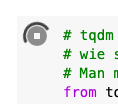

Danach können sie in den folgenden Zellen die Performance ihres trainierten Netzwerkes testen.

# Evaluation der Trainingskurven und der Ergebnisse auf dem Testset

Genau wie im Trainings-Notebook importieren wir zunächst einige Bibliotheken, die wir benutzen werden, richten unsere Umgebung ein und wählen die Graphikkarte, die wir für unsere Berechnungen benutzen.

### Trainingskurven
Zunächst schauen wir uns die Trainingskurven an. Falls z.B. die Learning-Rate zu groß ist und die Kostenfunktion explodiert, kann man das so sofort erkennen.

__Ohne eine Darstellung der Lernkurven, die zeigen, wie sich die Kostenfunktion auf dem Trainings- und Validierungsset während des Trainings entwickelt, sollte man keinem Deep-Learning-Ergebnis trauen.__

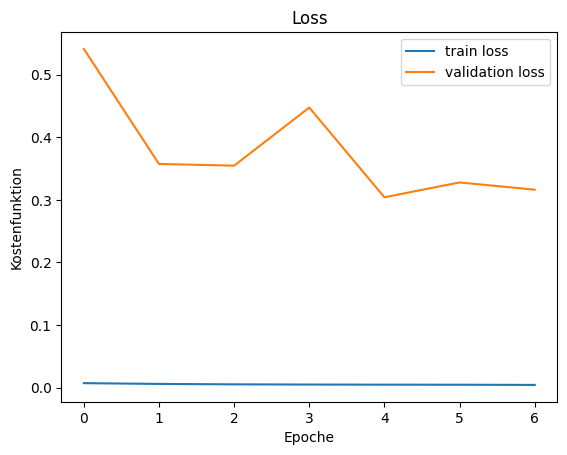

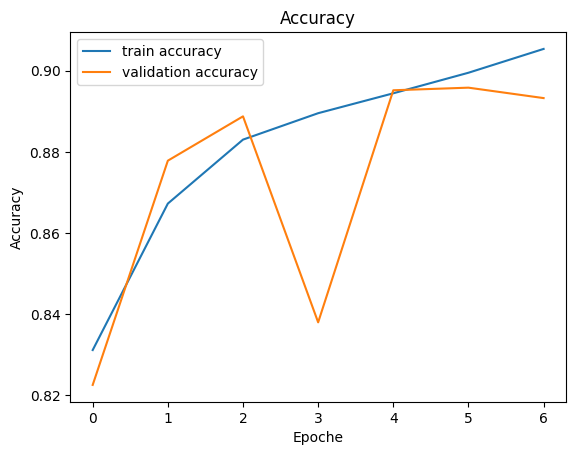

In [70]:
import matplotlib.pyplot as plt

# Wir teilen matplotlib mit, dass die Kurven direkt hier ins Notebook gezeichnet werden sollen.
%matplotlib inline

# Jetzt lesen wir die Metriken, die wir in der Trainingsschleife nach jeder Epoche gespeichert haben
from helper_functions_covid import read_log_data

log_file = 'log_train.txt'
log_data = read_log_data(log_file)

# Zuerst zeichnen wir eine Graphik, die die Lernkurven der Kostenfunktion ("loss") auf dem Trainings-
# und Validierungsset darstellt
plt.figure()
plt.title('Loss')
plt.plot(log_data['epoch'],log_data['train loss'],label="train loss")
plt.plot(log_data['epoch'],log_data['validation loss'],label="validation loss")
plt.xlabel('Epoche')
plt.ylabel('Kostenfunktion')
plt.legend(loc='best')
plt.show()

# Jetzt zeichnen wir noch eine Graphik, die die Lernkurven der Accuracy auf dem Trainings-
# und Validierungsset darstellt
plt.figure()
plt.title('Accuracy')
plt.plot(log_data['epoch'],log_data['train accuracy'],label="train accuracy")
plt.plot(log_data['epoch'],log_data['validation accuracy'],label="validation accuracy")
plt.legend(loc='best')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.show()

### Metriken auf dem Testset

Als nächstes schauen wir uns die Kennwerte des trainierten Netzwerkes auf dem unabhängigen Testset an, das wir bereits im Trainings-Notebook vorbereitet und gespeichert haben.

Dazu laden wir zunächst die Dateinamen aus den entsprechenden Listen, die wir im Trainings-Notebook erzeugt haben.

In [71]:
from helper_functions_covid import read_txt

filenames_normal_test = read_txt('filenames_normal_test.txt')
filenames_pneumonia_test = read_txt('filenames_pneumonia_test.txt')
filenames_covid_test = read_txt('filenames_covid_test.txt')

Jetzt erzeugen wir einen entsprechenden Datensatz, der diese Dateien so lädt und aufbereitet, dass das trainierte Netz sie verarbeiten kann.

In [75]:
from helper_functions_covid import ImageDataset, val_transformer, DataLoader

data_path = './covid_dataset_full/data'
batchsize = 8

testset = ImageDataset(root_dir=data_path,
                          classes = ['normal', 'pneumonia', 'COVID'],
                          files_path = [filenames_normal_test, filenames_pneumonia_test, filenames_covid_test],
                          transform= val_transformer)

test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

Nun können wir die Metriken auf dem Testset evaluieren.

In [76]:
from helper_functions_covid import compute_metrics

model = torch.load("best_model.pkl")

metrics_dict = compute_metrics(model, test_loader, device)
# Wir geben die entsprechenden Statistiken aus:
print('------------------ Test Metrics ----------------------------------------------')
print("Accuracy \t {:.3f}".format(metrics_dict['accuracy']))
print("Recall on normal test data \t {:.3f}".format(metrics_dict['recall_normal']))
print("Recall on pneumonia test data \t {:.3f}".format(metrics_dict['recall_pneumonia']))
print("Recall on COVID test data \t {:.3f}".format(metrics_dict['recall_covid']))
print("Test Loss \t {}".format(metrics_dict["validation loss"]))
print("------------------------------------------------------------------------------")

------------------ Test Metrics ----------------------------------------------
Accuracy 	 0.887
Recall on normal test data 	 0.904
Recall on pneumonia test data 	 0.904
Recall on COVID test data 	 0.484
Test Loss 	 0.30656481020343607
------------------------------------------------------------------------------


Nun erstellen wir auch noch die __"Confusion Matrix"__ für das trainierte Netzwerk auf dem Testset.

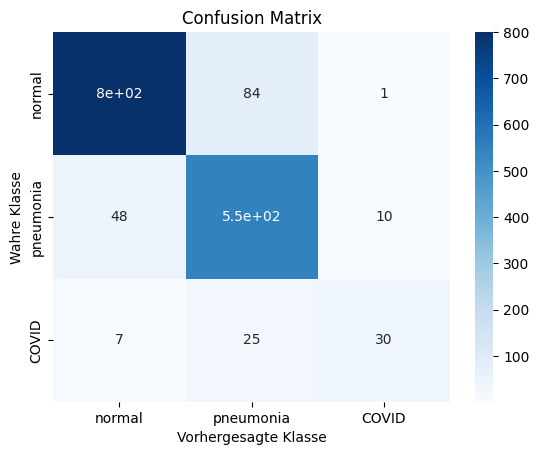

In [77]:
from helper_functions_covid import plot_confusion_matrix

conf_matrix = metrics_dict["confusion matrix"]

plot_confusion_matrix(conf_matrix)

### GradCAM

Ein häufig (zu recht) geäußerter Kritikpunkt an Deep-Learning-Methoden ist, dass es sich bei den trainierten Netzen um "Black Boxes" handelt. Aufgrund der schieren Komplexität und der Anzahl der freien Parameter ist es - im Gegensatz zu regelbasierten Systemen oder klassischen Algorithmen - nicht einfach, herauszufinden, nach welchen Regeln oder Kriterien ein neuronales Netzwerk seine Entscheidungen fällt.

Aufgrund der Bedeutung dieser Frage gibt es zum Glück einiges an Forschung und Fortschritt auf diesem Gebiet.

Ein Ansatz ist __Feature Attribution__: Feature Attribution bedeutet zu untersuchen, welche "Features" eines Datenpunktes den Output eines Classifiers am stärksten beeinflussen.

Bei der Klassifikation von Bilder kann man zum Beispiel untersuchen, welche Pixel eines Inputbildes die vorhergesagten Klassewahrscheinlichkeiten am stärksten beeinflussen würden, wenn man an diesen "ein wenig wackeln" würde.

Ein solcher Algorithmus ist z.B. [GradCAM](https://arxiv.org/abs/1610.02391), den wir auf unserem trainierten Netz ausprobieren wollen.

Besonders lehrreich ist das, wenn wir wissen, was die wirkliche Klasse eines Bildes ist, und welche Klasse das Netzwerk dem Datenpunkt zugeordnet hat.

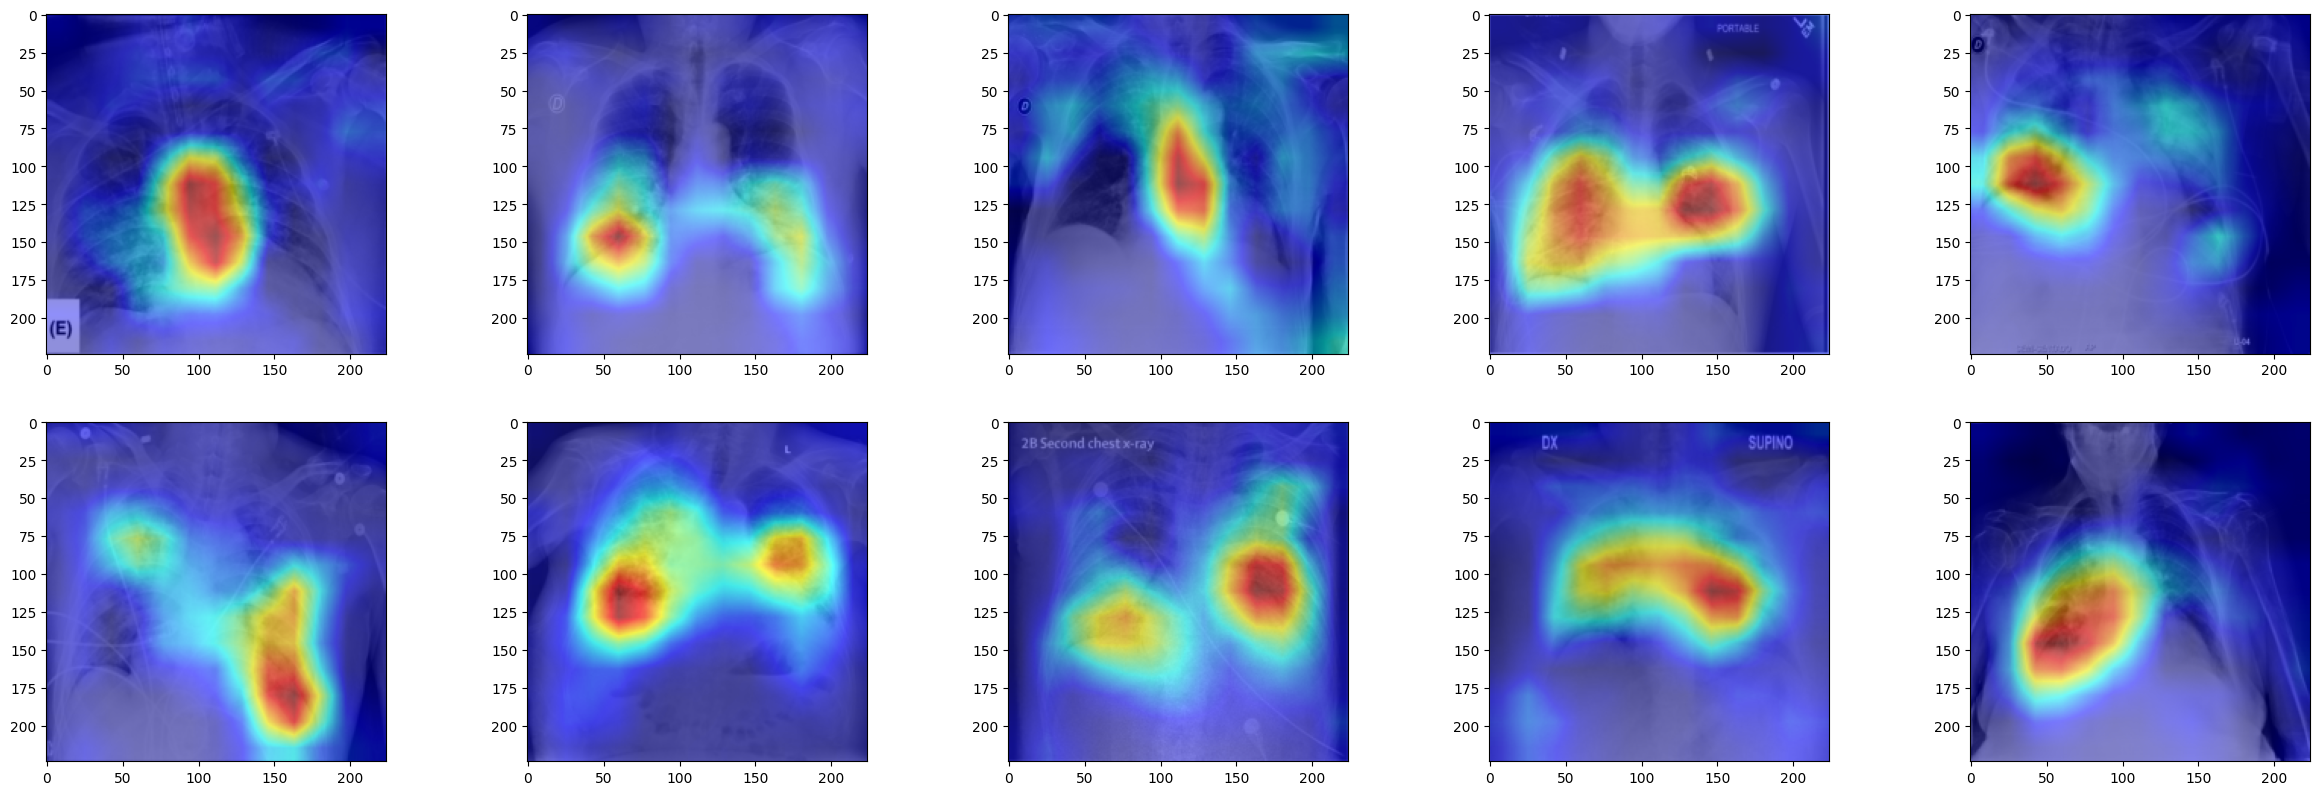

In [79]:
# Eventuell einmal pytorch-gradcam installieren und danach den Kernel nochmals neu starten,
# falls diese Zelle nicht ausführbar sein sollte:
# !pip install pytorch-gradcam


from helper_functions_covid import show_grad_cam

# Vorhersagen, die das Netz für die Bilder des Testsets gemacht hat
preds = metrics_dict["pred_list"]
# Wahre Klassen für die Bilder des Testsets
targets = metrics_dict["target_list"]
# Pfade zu den Bildern des Testsets
paths = metrics_dict["paths"]

# Diese Funktion erhält neben den vorhergesagten Klassen, den wahren Klassen und den Dateinamen
# der Datenpunkte aus dem Testset (preds, targets, paths) auch das trainierte Netzwerk (model).
# Die Funktion berechnet auf der Graphikkarte (device) die entsprechenden Feature-Attribution-Maps für
# zufällig gezogene Beispiele aus dem Testset, die vom Netzwerk als "predicted_label" klassifiziert
# wurden, in Wahrheit aber zur Klasse "true_label" gehören.
# D.h. wenn sie die Funktion so ausführen, zeigt sie Beispiele an, die als covid Klassifiziert wurden
# und auch wirklich zur Klasse "covid" gehören.
# Probieren sie gerne auch andere Kombinationen aus und beobachten sie, wie sich die Maps
# z.B. für korrekte und falsche Vorhersagen unterscheiden.
# Mögliche optionen für predicted_laben und true_label sind die Klassen unseres Datensatzes, also
# 'covid', 'normal' und 'pneumonia'
show_grad_cam(preds, targets, paths, model, device, predicted_label = 'pneumonia', true_label = 'covid')

Das wars. Wir hoffen, sie konnten in dieser Übung etwas lernen. Laden sie gerne die entsprechenden Bilder (mit Rechtsklick) herunter und kopieren sie die entsprechenden Statistiken, um sie dann in das Miro-Board zu kopieren, das wir für die Abschlussbesprechung verwenden möchten (Link auf HeiCONF).